# The pips

In [ ]:
!apt-get install tesseract-ocr
!apt-get install -y poppler-utils
!pip install pdf2image pytesseract
!pip install pypdf2 pdfplumber gensim sumy sentence_transformers
!pip install yake
!pip install openai
!pip install rake-nltk
!pip install rake-new2
!pip install nltk networkx
!pip install InstructorEmbedding
!pip install sentence_transformers
!pip install nltk rouge_score
!pip install psutil

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 16 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 1s (5,087 kB/s)
Selecting previously unselected package tesseract-ocr-eng.
(Reading database ... 120901 files and directories currently installed.)
Preparing to unpack .../tesseract-ocr-

# Imports

In [ ]:
from keyword_extractors import extract_keywords_rake,extract_keywords_rake_new2,extract_keywords_textrank,extract_keywords_yake
from summarization import textrank,lexrank,luhn
from word_embedding import create_embedding_davinci,create_embedding_ada
from Sentence_embedding  import generate_emb_doc_2_vec,generate_emb_sbert
from First_approach import First_approach


In [ ]:
import openai
import time
import psutil
import pandas as pd

# In these trails, we will make all the variables standard and change one , and get the best one , then applying it on the next trail, and so on ....

* We will use the similarity threshold to 0.8
* The in the evalution , we will use the sbert as it learns representations at a “subword” (also called WordPieces) level. Subwords can be thought of as a sweet spot between character-level embeddings and word-level embeddings.

(while Doc2Vec is an extension of Word2Vec, which captures the contextual meaning of words in a document. However, it may struggle to capture more nuanced semantic relationships between documents.)

According to this reference: "https://medium.com/swlh/differences-between-word2vec-and-bert-c08a3326b5d1"

# **Compare the embedding sentences using doc2vec vs sbert**

# DOC2VEC

In [ ]:
# Set the URL of the PDF you want to work with
pdf_url = "https://www.cell.com/the-innovation/pdf/S2666-6758(20)30036-9.pdf"
# Initialize the Words_Digest with the PDF URL
first_approch = First_approach(pdf_url)
# Measure the time it takes
start_time_doc2vec = time.time()
pdf_info = first_approch.kw_emb_store(extract_keywords_yake,generate_emb_doc_2_vec,create_embedding_ada)
end_time_doc2vec = time.time()
elapsed_time_doc2vec= end_time_doc2vec - start_time_doc2vec
print("Elapsed Time for store with the embeddding sentence (doc2vec):", elapsed_time_doc2vec, "seconds")

Elapsed Time for store with the embeddding sentence (doc2vec): 12.69568157196045 seconds


In [ ]:
# Set token and similarity thresholds
token_threshold = 2000
similarity_threshold = 0.8
# Create a list of indices from the stored PDF info
indices_only = [info[0] for info in pdf_info]
# Initialize a DataFrame to store the results
results_df = pd.DataFrame(columns=['Question','Response', 'Similarity_Score'])
# Initialize conversation history
conversation_history = []
# Start measuring time for the main loop
start_time1 = time.time()

while True:
    try:
        user_prompt = input("You: ")

        if user_prompt.lower() == "exit":
            break
        # Find similar paragraph indices based on user input and similarity threshold
        similar_paragraph_indices = first_approch.keyword_compare(user_prompt,create_embedding_ada,extract_keywords_yake, similarity_threshold=similarity_threshold)
        print ('similar_paragraph_indices:',similar_paragraph_indices)
        if len(similar_paragraph_indices) == 0:
            # Use all paragraph indices when no similar ones are found
            similar_paragraph_indices=indices_only
             # Get the top indices based on embeddings comparison
            top_indices = first_approch.embeddings_compare(similar_paragraph_indices, user_prompt, embedding_function=generate_emb_doc_2_vec)
            print ('top_indices:',top_indices)
            if len(top_indices) == 0:

              print('The answer to this question is not provided in this PDF')
              continue
            else:
              # Generate a summary and prompt for GPT-3
              summary = first_approch.tokens_check_and_summerization(user_prompt, top_indices, textrank, token_threshold=token_threshold)
              prompt = first_approch.prompt_generator(user_prompt, summary)
              conversation_history.append({"role": "user", "content": prompt})
              # Generate a response from GPT-3
              response = first_approch.run_chatgpt(conversation_history)
              print("Assistant's Response:", response)
              # Calculate similarity percentage
              similarity_percentage = first_approch.evaluation(summary, response,embedding_function=generate_emb_sbert)
              print("Similarity Percentage:", similarity_percentage)
              conversation_history.append({"role": "assistant", "content": response})

        else:
          # Get the top indices based on embeddings comparison
            top_indices = first_approch.embeddings_compare(similar_paragraph_indices, user_prompt, embedding_function=generate_emb_doc_2_vec)
            print ('top_indices:',top_indices)
            # Generate a summary and prompt for GPT-3
            summary = first_approch.tokens_check_and_summerization(user_prompt, top_indices, textrank, token_threshold=token_threshold)
            prompt = first_approch.prompt_generator(user_prompt, summary)
            conversation_history.append({"role": "user", "content": prompt})
            # Generate a response from GPT-3
            response = first_approch.run_chatgpt(conversation_history)
            print("Assistant's Response:", response)
            # Calculate similarity percentage
            similarity_percentage = first_approch.evaluation(summary, response, embedding_function=generate_emb_sbert)
            print("Similarity Percentage:", similarity_percentage)
            conversation_history.append({"role": "assistant", "content": response})
            # Append question, response, and similarity score to the DataFrame
            results_df = results_df.append({'Question': user_prompt, 'Response' : response ,'Similarity_Score': similarity_percentage}, ignore_index=True)
    except openai.error.InvalidRequestError as e:
        print("Error:", e)
        print("Total token count exceeded. Exiting...")
        break

# Measure elapsed time and memory usage
end_time1 = time.time()
elapsed_time1 = end_time1 - start_time1
print("Elapsed Time:", elapsed_time1, "seconds")

# Measure memory usage
process1 = psutil.Process()
memory_usage1 = process1.memory_info().rss / (1024 * 1024)  # in MB
print("Memory Usage:", memory_usage1, "MB")

#What are the main scientific and technical challenges involved in Mars exploration and potential human migration to Mars?
#What scientific themes and specific issues are addressed in Mars exploration missions?
#How does the Mars exploration shift from focusing on the Moon to considering Mars as a potential destination for humanity?
# How many missions had done in 2020?
# What will Perseverance rover do?
# What is Hope?
# What were the three sequential Mars exploration missions in 2020?

You: What are the main scientific and technical challenges involved in Mars exploration and potential human migration to Mars?
similar_paragraph_indices: [4, 5, 7, 8, 12]
top_indices: [5, 8, 7, 4, 12]
Ratio between token_size_summary and token_size_paragraph: 100
Assistant's Response: The main scientific and technical challenges involved in Mars exploration and potential human migration to Mars include:

1. Landing on Mars: Landing safely on Mars is a difficult challenge due to the thin atmosphere and the risk of entry, descent, and landing. It requires precise calculations and advanced landing technologies.

2. Global remote sensing and detailed surveys: Mars exploration involves conducting global remote sensing to understand the planet's overall characteristics and conducting detailed surveys on specific areas of interest. This requires the integration of advanced imaging and sensing technologies.

3. In-depth studies: In addition to remote sensing, in-depth studies are needed to exp

/usr/local/lib/python3.10/dist-packages/sentence_transformers/util.py:36: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  a = torch.tensor(a)
<ipython-input-5-988b5f1e52e0>:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Question': user_prompt, 'Response' : response ,'Similarity_Score': similarity_percentage}, ignore_index=True)


Similarity Percentage: tensor(79.4419)
You: What scientific themes and specific issues are addressed in Mars exploration missions?
similar_paragraph_indices: [4, 5, 7, 8]
top_indices: [7, 4, 8, 5]
Ratio between token_size_summary and token_size_paragraph: 100
Assistant's Response: The scientific themes addressed in Mars exploration missions include:

1. Global remote sensing: Mars exploration missions aim to understand the overall characteristics of the planet through global remote sensing. This involves studying the geology, atmosphere, and environmental conditions on Mars.

2. Detailed surveys on landing areas: In addition to global remote sensing, missions conduct detailed surveys on specific landing areas of interest. These surveys provide a more in-depth understanding of the geological structure and environment in these areas.

3. Internal structure of Mars: The InSight mission specifically focuses on studying the internal structure of Mars, including its crust, mantle, and core. 

<ipython-input-5-988b5f1e52e0>:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Question': user_prompt, 'Response' : response ,'Similarity_Score': similarity_percentage}, ignore_index=True)


Similarity Percentage: tensor(80.4855)
You: How does the Mars exploration shift from focusing on the Moon to considering Mars as a potential destination for humanity?
similar_paragraph_indices: [4, 5, 7, 8]
top_indices: [7, 8, 4, 5]
Ratio between token_size_summary and token_size_paragraph: 100
Error: This model's maximum context length is 4097 tokens. However, your messages resulted in 4358 tokens. Please reduce the length of the messages.
Total token count exceeded. Exiting...
Elapsed Time: 54.459360122680664 seconds
Memory Usage: 1047.27734375 MB


In [ ]:
# Print dataframe which contains the similaruty score with the question and the response
results_df

,Question,Response,Similarity_Score
0,What are the main scientific and technical cha...,The main scientific and technical challenges i...,tensor(79.4419)
1,What scientific themes and specific issues are...,The scientific themes addressed in Mars explor...,tensor(80.4855)


# SBERT


In [ ]:
# Set the URL of the PDF you want to work with
pdf_url = "https://www.cell.com/the-innovation/pdf/S2666-6758(20)30036-9.pdf"
# Initialize the Words_Digest with the PDF URL
first_approch = First_approach(pdf_url)
# Measure the time it takes
start_time_sbert = time.time()
pdf_info = first_approch.kw_emb_store(extract_keywords_yake,generate_emb_sbert,create_embedding_ada)
end_time_sbert = time.time()
elapsed_time_sbert= end_time_sbert - start_time_sbert
print("Elapsed Time for store with the embeddding sentence (sbert):", elapsed_time_sbert, "seconds")

Elapsed Time for store with the embeddding sentence (sbert): 21.887112617492676 seconds


In [ ]:
# Set token and similarity thresholds
token_threshold = 2000
similarity_threshold = 0.8
# Create a list of indices from the stored PDF info
indices_only = [info[0] for info in pdf_info]
# Initialize a DataFrame to store the results
results_df_sbert = pd.DataFrame(columns=['Question','Response', 'Similarity_Score'])
# Initialize conversation history
conversation_history = []
# Start measuring time for the main loop
start_time = time.time()

while True:
    try:
        user_prompt = input("You: ")

        if user_prompt.lower() == "exit":
            break
        # Find similar paragraph indices based on user input and similarity threshold
        similar_paragraph_indices = first_approch.keyword_compare(user_prompt,create_embedding_ada,extract_keywords_yake, similarity_threshold=similarity_threshold)
        print ('similar_paragraph_indices:',similar_paragraph_indices)
        if len(similar_paragraph_indices) == 0:
           # Use all paragraph indices when no similar ones are found
            similar_paragraph_indices=indices_only
            # Get the top indices based on embeddings comparison
            top_indices = first_approch.embeddings_compare(similar_paragraph_indices, user_prompt, embedding_function=generate_emb_sbert)
            print ('top_indices:',top_indices)
            if len(top_indices) == 0:
              print('The answer to this question is not provided in this PDF')
              continue
            else:
              # Generate a summary and prompt for GPT-3
              summary = first_approch.tokens_check_and_summerization(user_prompt, top_indices, textrank, token_threshold=token_threshold)
              prompt = first_approch.prompt_generator(user_prompt, summary)
              conversation_history.append({"role": "user", "content": prompt})
               # Generate a response from GPT-3
              response = first_approch.run_chatgpt(conversation_history)
              print("Assistant's Response:", response)
              # Calculate similarity percentage
              similarity_percentage = first_approch.evaluation(summary, response,embedding_function=generate_emb_sbert)
              print("Similarity Percentage:", similarity_percentage)
              conversation_history.append({"role": "assistant", "content": response})

        else:
          # Get the top indices based on embeddings comparison
            top_indices = first_approch.embeddings_compare(similar_paragraph_indices, user_prompt, embedding_function=generate_emb_sbert)
            print ('top_indices:',top_indices)
            # Generate a summary and prompt for GPT-3
            summary = first_approch.tokens_check_and_summerization(user_prompt, top_indices, textrank, token_threshold=token_threshold)
            prompt = first_approch.prompt_generator(user_prompt, summary)
            conversation_history.append({"role": "user", "content": prompt})
             # Generate a response from GPT-3
            response = first_approch.run_chatgpt(conversation_history)
            print("Assistant's Response:", response)
            # Calculate similarity percentage
            similarity_percentage = first_approch.evaluation(summary, response, embedding_function=generate_emb_sbert)
            print("Similarity Percentage:", similarity_percentage)
            conversation_history.append({"role": "assistant", "content": response})
            # Append question, response, and similarity score to the DataFrame
            results_df_sbert = results_df_sbert.append({'Question': user_prompt, 'Response' : response ,'Similarity_Score': similarity_percentage}, ignore_index=True)
    except openai.error.InvalidRequestError as e:
        print("Error:", e)
        print("Total token count exceeded. Exiting...")
        break

# Measure elapsed time and memory usage
end_time = time.time()
elapsed_time = end_time - start_time
print("Elapsed Time:", elapsed_time, "seconds")

# Measure memory usage
process = psutil.Process()
memory_usage = process.memory_info().rss / (1024 * 1024)  # in MB
print("Memory Usage:", memory_usage, "MB")

#What are the main scientific and technical challenges involved in Mars exploration and potential human migration to Mars?
#What scientific themes and specific issues are addressed in Mars exploration missions?
#How does the Mars exploration shift from focusing on the Moon to considering Mars as a potential destination for humanity?
# How many missions had done in 2020?
# What will Perseverance rover do?
# What is Hope?
# What were the three sequential Mars exploration missions in 2020?

You: What are the main scientific and technical challenges involved in Mars exploration and potential human migration to Mars?
similar_paragraph_indices: [4, 5, 7, 8, 12]
top_indices: [8, 7, 5, 4, 12]
Ratio between token_size_summary and token_size_paragraph: 100
Assistant's Response: The main scientific and technical challenges involved in Mars exploration and potential human migration to Mars include:

1. Landing on Mars: Landing on Mars is a difficult challenge due to its thin atmosphere and the distance from Earth. It requires precise navigation and landing technologies to ensure a successful touchdown.

2. Mars exploration themes: Mars exploration involves a wide range of scientific themes, including global remote sensing and detailed surveys on landing in specific areas of interest. These themes require diverse talents and the integration of advanced innovations.

3. In-depth surveys: In addition to general exploration, in-depth surveys of specific issues on Mars are required. Fo

<ipython-input-9-2cd1640c6ef7>:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df_sbert = results_df_sbert.append({'Question': user_prompt, 'Response' : response ,'Similarity_Score': similarity_percentage}, ignore_index=True)


Similarity Percentage: tensor(84.0068)
You: What scientific themes and specific issues are addressed in Mars exploration missions?
similar_paragraph_indices: [4, 5, 7, 8]
top_indices: [8, 7, 5, 4]
Ratio between token_size_summary and token_size_paragraph: 100
Assistant's Response: The scientific themes addressed in Mars exploration missions include:

1. Global remote sensing: Mars missions aim to gather data on a global scale, such as mapping the topography, studying the composition of the Martian surface, and monitoring the weather and atmospheric conditions.

2. Detailed surveys on landing: Mars missions conduct detailed surveys of specific areas of interest, including studying the geological structure, environment, atmosphere, and subsurface water. These surveys provide valuable insights into the history and potential habitability of Mars.

3. Internal structure exploration: InSight is a mission specifically designed to explore the internal structure of Mars. It uses instruments lik

<ipython-input-9-2cd1640c6ef7>:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df_sbert = results_df_sbert.append({'Question': user_prompt, 'Response' : response ,'Similarity_Score': similarity_percentage}, ignore_index=True)


Similarity Percentage: tensor(83.6487)
You: How does the Mars exploration shift from focusing on the Moon to considering Mars as a potential destination for humanity?
similar_paragraph_indices: [4, 5, 7, 8]
top_indices: [8, 7, 5, 4]
Ratio between token_size_summary and token_size_paragraph: 100
Error: This model's maximum context length is 4097 tokens. However, your messages resulted in 4436 tokens. Please reduce the length of the messages.
Total token count exceeded. Exiting...
Elapsed Time: 52.59719657897949 seconds
Memory Usage: 1049.515625 MB


In [ ]:
# Print dataframe which contains the similaruty score with the question and the response
results_df_sbert

,Question,Response,Similarity_Score
0,What are the main scientific and technical cha...,The main scientific and technical challenges i...,tensor(84.0068)
1,What scientific themes and specific issues are...,The scientific themes addressed in Mars explor...,tensor(83.6487)


#Plot the memory usage , loaded time and the time elapsed

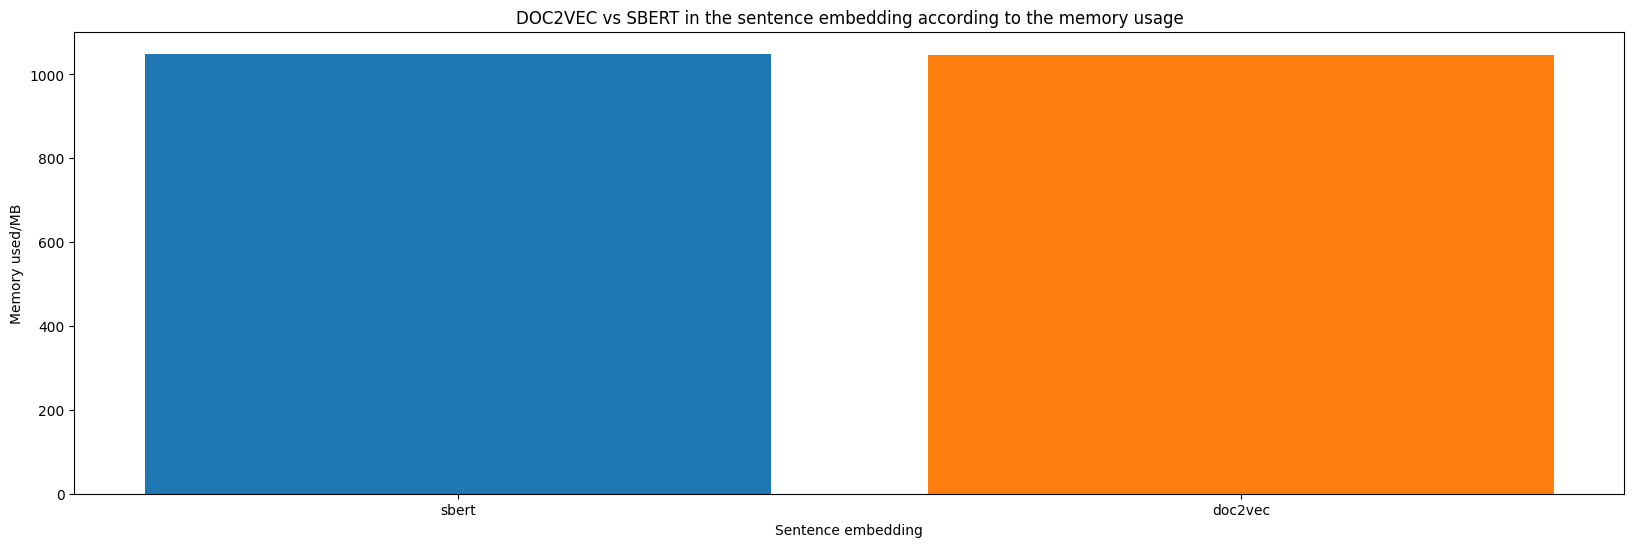

In [ ]:
import matplotlib.pyplot as plt

# Plot the results
plt.figure(figsize=(20, 6))

for threshold, question_count in [('sbert', memory_usage),
                                  ('doc2vec', memory_usage1),
                                 ]:
    plt.bar(str(threshold), question_count)

plt.xlabel('Sentence embedding')
plt.ylabel('Memory used/MB')
plt.title('DOC2VEC vs SBERT in the sentence embedding according to the memory usage')
plt.show()


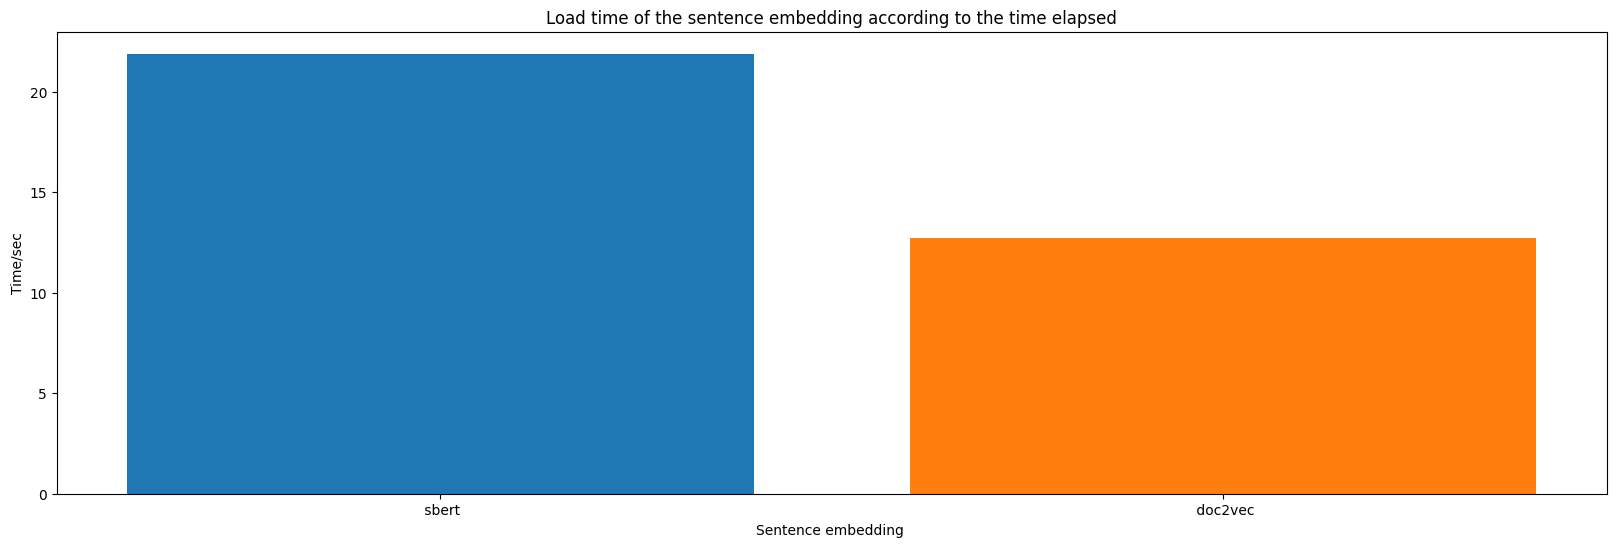

In [ ]:
import matplotlib.pyplot as plt

# Plot the results
plt.figure(figsize=(20, 6))

for threshold, question_count in [(' sbert', elapsed_time_sbert),
                                  (' doc2vec', elapsed_time_doc2vec),

                                 ]:
    plt.bar(str(threshold), question_count)

plt.xlabel('Sentence embedding ')
plt.ylabel('Time/sec')
plt.title('Load time of the sentence embedding according to the time elapsed')
plt.show()


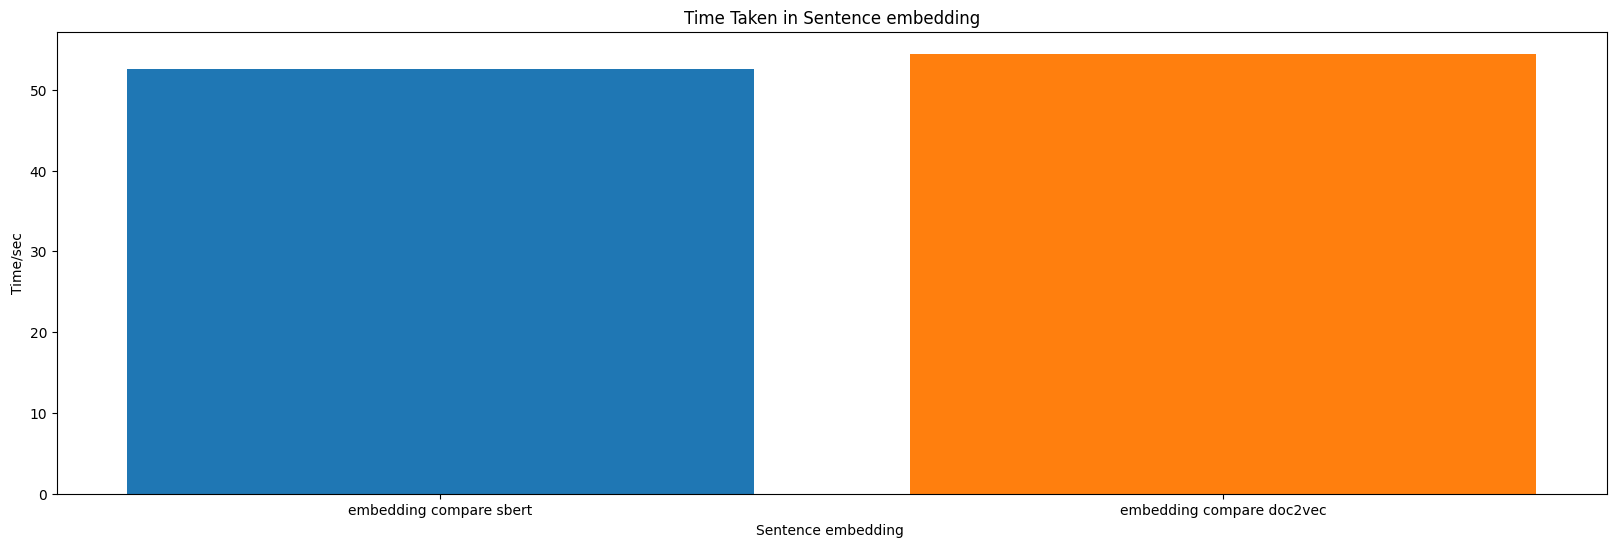

In [ ]:
import matplotlib.pyplot as plt

# Plot the results
plt.figure(figsize=(20, 6))

for threshold, question_count in [
                                  ('embedding compare sbert', elapsed_time),
                                  ('embedding compare doc2vec', elapsed_time1),

                                 ]:
    plt.bar(str(threshold), question_count)

plt.xlabel('Sentence embedding ')
plt.ylabel('Time/sec')
plt.title('Time Taken in Sentence embedding')
plt.show()


* We will use the doc2vec as an embedding compare library as it takes less time with the whole trials
* The memory usage is almost the same
* The respnses of the questions are the same in both (doc2vec and sbert)
* Both gave the same top 5 similar indeces
* We tried it with (ada-> word embedding , yake -> keyword extractor , textrank -> summarization library)


# **Here, we will change the threshold with different values**



We will use the doc2vec that comes from the previous trial

In [ ]:
import openai
import time
import psutil

def check_for_threshold(pdf_url, token_threshold, similarity_threshold):
    # Initialize the first_approch with the PDF URL
    first_approch = First_approach(pdf_url)
    pdf_info = first_approch.kw_emb_store(extract_keywords_yake,generate_emb_doc_2_vec,create_embedding_ada)
    indices_only = [info[0] for info in pdf_info]
    # Initialize dictionary to store threshold counts
    threshold_count = {}
    question_count = 0
    conversation_history = []
    start_time_ = time.time()

    while True:
        try:
            user_prompt = input("You: ")

            if user_prompt.lower() == "exit":
                break
            # Find similar paragraph indices based on user input and similarity threshold
            similar_paragraph_indices = first_approch.keyword_compare(user_prompt,create_embedding_ada,extract_keywords_yake, similarity_threshold=similarity_threshold)
            print ('similar_paragraph_indices:',similar_paragraph_indices)
            if len(similar_paragraph_indices) == 0:
                similar_paragraph_indices=indices_only
                # Get the top indices based on embeddings comparison
                top_indices = first_approch.embeddings_compare(similar_paragraph_indices, user_prompt, embedding_function=generate_emb_doc_2_vec)
                print ('top_indices:',top_indices)
                if len(top_indices) == 0:
                  print('The answer to this question is not provided in this PDF')
                  continue
                else:
                   # Generate a summary and prompt for GPT-3
                  summary = first_approch.tokens_check_and_summerization(user_prompt, top_indices, textrank, token_threshold=token_threshold)
                  prompt = first_approch.prompt_generator(user_prompt, summary)
                  conversation_history.append({"role": "user", "content": prompt})
                  # Generate a response from GPT-3
                  response = first_approch.run_chatgpt(conversation_history)
                  print("Assistant's Response:", response)
                  # Calculate similarity percentage
                  similarity_percentage = first_approch.evaluation(summary, response,embedding_function=generate_emb_sbert)
                  conversation_history.append({"role": "assistant", "content": response})
                  # Calculate the number of the questions
                  actual_threshold = len(summary.split())
                  if actual_threshold not in threshold_count:
                      threshold_count[actual_threshold] = 1
                  else:
                      threshold_count[actual_threshold] += 1
                  question_count += 1

            else:

                top_indices = first_approch.embeddings_compare(similar_paragraph_indices, user_prompt, embedding_function=generate_emb_doc_2_vec)
                print ('top_indices:',top_indices)
                # Generate a summary and prompt for GPT-3
                summary = first_approch.tokens_check_and_summerization(user_prompt, top_indices, textrank, token_threshold=token_threshold)
                prompt = first_approch.prompt_generator(user_prompt, summary)
                conversation_history.append({"role": "user", "content": prompt})
                 # Generate a response from GPT-3
                response = first_approch.run_chatgpt(conversation_history)
                print("Assistant's Response:", response)
                # Calculate similarity percentage
                similarity_percentage = first_approch.evaluation(summary, response, embedding_function=generate_emb_sbert)
                conversation_history.append({"role": "assistant", "content": response})
                # Calculate the number of the questions
                actual_threshold = len(summary.split())
                if actual_threshold not in threshold_count:
                    threshold_count[actual_threshold] = 1
                else:
                    threshold_count[actual_threshold] += 1
                question_count += 1
        except openai.error.InvalidRequestError as e:
            print("Error:", e)
            print("Total token count exceeded. Exiting...")
            break

    print("Threshold:", token_threshold)
    print("Threshold Count:", threshold_count)
    print("Number of questions:", question_count)
    # Measure elapsed time
    end_time_ = time.time()
    elapsed_time_ = end_time_ - start_time_
    print("Elapsed Time:", elapsed_time_, "seconds")

    # Measure memory usage
    process_ = psutil.Process()
    memory_usage_ = process_.memory_info().rss / (1024 * 1024)  # in MB
    print("Memory Usage:", memory_usage_, "MB")
    return token_threshold, question_count

# Threshold = 2000

In [ ]:
pdf_url = "https://www.cell.com/the-innovation/pdf/S2666-6758(20)30036-9.pdf"
token_threshold_1 = 2000
similarity_threshold_1 = 0.8

trial1_threshold_count_2000, trial1_threshold_count_2000_question = check_for_threshold(pdf_url, token_threshold_1, similarity_threshold_1)

    #What are the main scientific and technical challenges involved in Mars exploration and potential human migration to Mars?
    #What scientific themes and specific issues are addressed in Mars exploration missions?
    #How does the Mars exploration shift from focusing on the Moon to considering Mars as a potential destination for humanity?
    # How many missions had done in 2020?
    # What will Perseverance rover do?
    # What is Hope?
    # What were the three sequential Mars exploration missions in 2020?

You: What are the main scientific and technical challenges involved in Mars exploration and potential human migration to Mars?
similar_paragraph_indices: [4, 5, 7, 8, 12]
top_indices: [5, 8, 7, 4, 12]
Ratio between token_size_summary and token_size_paragraph: 100
Assistant's Response: The main scientific and technical challenges involved in Mars exploration and potential human migration to Mars include:

1. Landing on Mars: Landing on Mars is a difficult challenge due to its thin atmosphere and the need for precision navigation and landing techniques. It requires the development of advanced technologies and systems to safely land spacecraft and potentially human habitats on the Martian surface.

2. Environmental conditions: Mars has a harsh environment with extreme temperatures, high levels of radiation, and a thin atmosphere. Protecting astronauts from these conditions and providing them with life support systems, such as oxygen, water, and food, pose significant challenges.

3. Long-

# Threshold = 800

In [ ]:
pdf_url = "https://www.cell.com/the-innovation/pdf/S2666-6758(20)30036-9.pdf"
token_threshold_2 = 800
similarity_threshold_2 = 0.8

trial2_threshold_count_800, trial2_threshold_count_800_question = check_for_threshold(pdf_url, token_threshold_2, similarity_threshold_2)

    #What are the main scientific and technical challenges involved in Mars exploration and potential human migration to Mars?
    #What scientific themes and specific issues are addressed in Mars exploration missions?
    #How does the Mars exploration shift from focusing on the Moon to considering Mars as a potential destination for humanity?
    # How many missions had done in 2020?
    # What will Perseverance rover do?
    # What is Hope?
    # What were the three sequential Mars exploration missions in 2020?

You: What are the main scientific and technical challenges involved in Mars exploration and potential human migration to Mars?
similar_paragraph_indices: [4, 5, 7, 8, 12]
top_indices: [5, 8, 7, 4, 12]
Ratio between token_size_summary and token_size_paragraph: 77.19486081370451
Assistant's Response: The main scientific and technical challenges involved in Mars exploration and potential human migration to Mars include:

1. Landing on Mars: Landing a spacecraft on Mars is a difficult challenge due to the planet's thin atmosphere and the need for precise navigation and touchdown capabilities.

2. Remote Sensing and Surveys: Mars exploration requires global remote sensing and detailed surveys of specific areas of interest. This involves using advanced instruments and techniques to study the planet's geology, climate, atmosphere, and potential for past or present life.

3. Sample Collection and Return: Collecting samples from Mars and bringing them back to Earth is an important objective for

# Threshold = 500

In [ ]:
pdf_url = "https://www.cell.com/the-innovation/pdf/S2666-6758(20)30036-9.pdf"
token_threshold_3 = 500
similarity_threshold_3 = 0.8

trial3_threshold_count_500, trial3_threshold_count_500_question = check_for_threshold(pdf_url, token_threshold_3, similarity_threshold_3)

    #What are the main scientific and technical challenges involved in Mars exploration and potential human migration to Mars?
    #What scientific themes and specific issues are addressed in Mars exploration missions?
    #How does the Mars exploration shift from focusing on the Moon to considering Mars as a potential destination for humanity?
    # How many missions had done in 2020?
    # What will Perseverance rover do?
    # What is Hope?
    # What were the three sequential Mars exploration missions in 2020?

You: What are the main scientific and technical challenges involved in Mars exploration and potential human migration to Mars?
similar_paragraph_indices: [4, 5, 7, 8, 12]
top_indices: [5, 8, 7, 4, 12]
Ratio between token_size_summary and token_size_paragraph: 48.17987152034261
Assistant's Response: The main scientific and technical challenges involved in Mars exploration and potential human migration to Mars include:
1. Landing on Mars: Landing on Mars is a difficult challenge due to its thin atmosphere and the need for precise landing accuracy to ensure the safety of rovers and future manned missions.
2. Remote sensing: Mars exploration includes global remote sensing to gather comprehensive data about the planet, its atmosphere, geology, and potential resources. This requires advanced imaging technologies and instruments.
3. Detailed surveys: In addition to remote sensing, detailed surveys are needed to study specific areas of interest on Mars. This involves in-depth investigations of

# Threshold = 300

In [ ]:
pdf_url = "https://www.cell.com/the-innovation/pdf/S2666-6758(20)30036-9.pdf"
token_threshold_4 = 300
similarity_threshold_4 = 0.8

trial4_threshold_count_300, trial4_threshold_count_300_question = check_for_threshold(pdf_url, token_threshold_4, similarity_threshold_4)

    #What are the main scientific and technical challenges involved in Mars exploration and potential human migration to Mars?
    #What scientific themes and specific issues are addressed in Mars exploration missions?
    #How does the Mars exploration shift from focusing on the Moon to considering Mars as a potential destination for humanity?
    # How many missions had done in 2020?
    # What will Perseverance rover do?
    # What is Hope?
    # What were the three sequential Mars exploration missions in 2020?

You: What are the main scientific and technical challenges involved in Mars exploration and potential human migration to Mars?
similar_paragraph_indices: [4, 5, 7, 8, 12]
top_indices: [5, 8, 7, 4, 12]
Ratio between token_size_summary and token_size_paragraph: 28.4796573875803
Assistant's Response: The main scientific and technical challenges involved in Mars exploration and potential human migration to Mars include:

1. Long-distance travel: The journey to Mars takes several months, and sustaining the well-being of astronauts for such a long duration in space is a major challenge. This includes managing radiation exposure, psychological and physiological effects of microgravity, and providing adequate life support systems.

2. Entry, descent, and landing: The process of landing spacecraft on Mars is complex and challenging due to the thin atmosphere and the need for precise control. Developing technologies for safe and accurate landing is crucial to ensure the success of missions.

3. 

# Plot the number of the questions with the threshold

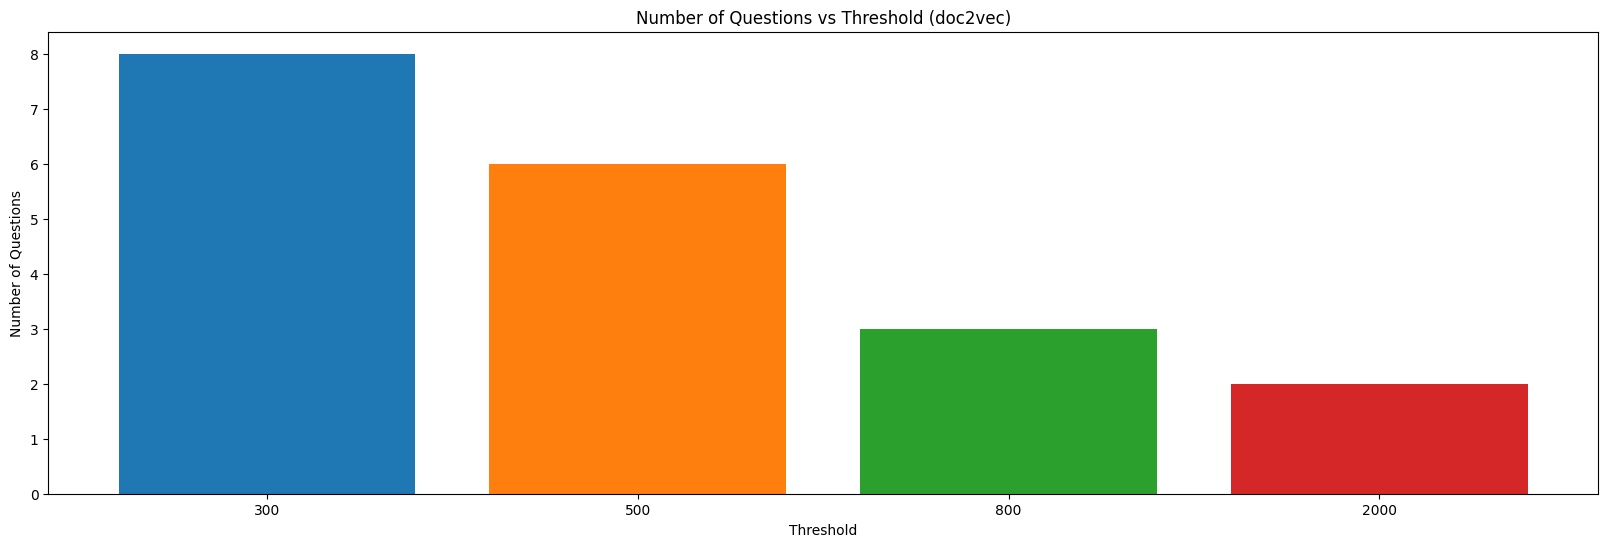

In [ ]:
import matplotlib.pyplot as plt

# Plot the results
plt.figure(figsize=(20, 6))

for threshold, question_count in [(token_threshold_4, trial4_threshold_count_300_question),
                                  (token_threshold_3, trial3_threshold_count_500_question),
                                  (token_threshold_2, trial2_threshold_count_800_question),
                                  (token_threshold_1, trial1_threshold_count_2000_question),
                                  # Add more pairs here for additional trials
                                 ]:
    plt.bar(str(threshold), question_count)

plt.xlabel('Threshold')
plt.ylabel('Number of Questions')
plt.title('Number of Questions vs Threshold (doc2vec)')
plt.show()

* When we decrease the threshold , the time elapsed and the memory usage increses as it needs more questions
* Here, we found that the threshold with the value = 300 takes larger number of questions than the others
* But it losses information
* So, we compare the rest of the results (the response) and we chose the threshold with value = 500
* 500 takes larger number of questions than 800 & 2000 and did not loss information

* So, we will complete with 500 threshold with the doc2vec as an embedding library(in the store function and the embedding compare function)

# **We will try different keyword extractor libraries**

##RAKE_NEW_2

In [ ]:
# Set the URL of the PDF you want to work with
pdf_url = "https://www.cell.com/the-innovation/pdf/S2666-6758(20)30036-9.pdf"
# Initialize the Words_Digest with the PDF URL
first_approch = First_approach(pdf_url)
# Measure the time it takes
start_time_rakenew2 = time.time()
pdf_info = first_approch.kw_emb_store(extract_keywords_rake_new2,generate_emb_doc_2_vec,create_embedding_ada)
end_time_rakenew2 = time.time()
elapsed_time_rakenew2= end_time_rakenew2 - start_time_rakenew2
print("Elapsed Time for store with the keyword extraction (rakenew2):", elapsed_time_rakenew2, "seconds")

Elapsed Time for store with the keyword extraction (rakenew2): 15.755882024765015 seconds


In [ ]:
# Set token and similarity thresholds
token_threshold = 500
similarity_threshold = 0.8
# Create a list of indices from the stored PDF info
indices_only = [info[0] for info in pdf_info]
# Initialize conversation history
conversation_history = []
# Start measuring time for the main loop
start_time2 = time.time()

while True:
    try:
        user_prompt = input("You: ")

        if user_prompt.lower() == "exit":
            break
        # Find similar paragraph indices based on user input and similarity threshold
        similar_paragraph_indices = first_approch.keyword_compare(user_prompt,create_embedding_ada,extract_keywords_rake_new2, similarity_threshold=similarity_threshold)
        print ('similar_paragraph_indices:',similar_paragraph_indices)
        if len(similar_paragraph_indices) == 0:
            # Use all paragraph indices when no similar ones are found
            similar_paragraph_indices=indices_only
            # Get the top indices based on embeddings comparison
            top_indices = first_approch.embeddings_compare(similar_paragraph_indices, user_prompt, embedding_function=generate_emb_doc_2_vec)
            print ('top_indices:',top_indices)
            if len(top_indices) == 0:
              print('The answer to this question is not provided in this PDF')
              continue
            else:
              # Generate a summary and prompt for GPT-3
              summary = first_approch.tokens_check_and_summerization(user_prompt, top_indices, textrank, token_threshold=token_threshold)
              prompt = first_approch.prompt_generator(user_prompt, summary)
              conversation_history.append({"role": "user", "content": prompt})
              # Generate a response from GPT-3
              response = first_approch.run_chatgpt(conversation_history)
              print("Assistant's Response:", response)
              # Calculate similarity percentage
              similarity_percentage = first_approch.evaluation(summary, response,embedding_function=generate_emb_sbert)
              conversation_history.append({"role": "assistant", "content": response})

        else:
            top_indices = first_approch.embeddings_compare(similar_paragraph_indices, user_prompt, embedding_function=generate_emb_doc_2_vec)
            print ('top_indices:',top_indices)
            # Generate a summary and prompt for GPT-3
            summary = first_approch.tokens_check_and_summerization(user_prompt, top_indices, textrank, token_threshold=token_threshold)
            prompt = first_approch.prompt_generator(user_prompt, summary)
            conversation_history.append({"role": "user", "content": prompt})
            # Generate a response from GPT-3
            response = first_approch.run_chatgpt(conversation_history)
            print("Assistant's Response:", response)
            # Calculate similarity percentage
            similarity_percentage = first_approch.evaluation(summary, response, embedding_function=generate_emb_sbert)
            conversation_history.append({"role": "assistant", "content": response})


    except openai.error.InvalidRequestError as e:
        print("Error:", e)
        print("Total token count exceeded. Exiting...")
        break

# Measure elapsed time
end_time2 = time.time()
elapsed_time2 = end_time2 - start_time2
print("Elapsed Time:", elapsed_time2, "seconds")

# Measure memory usage
process2 = psutil.Process()
memory_usage2 = process2.memory_info().rss / (1024 * 1024)  # in MB
print("Memory Usage:", memory_usage2, "MB")

#What are the main scientific and technical challenges involved in Mars exploration and potential human migration to Mars?
#What scientific themes and specific issues are addressed in Mars exploration missions?
#How does the Mars exploration shift from focusing on the Moon to considering Mars as a potential destination for humanity?
# How many missions had done in 2020?
# What will Perseverance rover do?
# What is Hope?
# What were the three sequential Mars exploration missions in 2020?

You: What are the main scientific and technical challenges involved in Mars exploration and potential human migration to Mars?
similar_paragraph_indices: [0, 4, 7, 8]
top_indices: [8, 7, 4, 0]
Ratio between token_size_summary and token_size_paragraph: 57.21455457967378
Assistant's Response: The main scientific and technical challenges involved in Mars exploration and potential human migration to Mars include:

1. Landing on Mars: One of the most difficult challenges is successfully landing spacecraft on Mars. This requires advanced landing systems and technologies to safely enter the Martian atmosphere and land on its surface.

2. Mars exploration themes: Mars exploration covers a wide range of scientific themes, from global remote sensing to detailed surveys of specific areas of interest. Each theme requires specialized instruments and techniques to gather data and conduct research.

3. Martian atmosphere and environment: Understanding the thin Martian atmosphere and its impact on hum

##RAKE

In [ ]:
# Set the URL of the PDF you want to work with
pdf_url = "https://www.cell.com/the-innovation/pdf/S2666-6758(20)30036-9.pdf"
# Initialize the Words_Digest with the PDF URL
first_approch = First_approach(pdf_url)
# Measure the time it takes to store keyword embeddings
start_time_rake = time.time()
pdf_info = first_approch.kw_emb_store(extract_keywords_rake,generate_emb_doc_2_vec,create_embedding_ada)
end_time_rake = time.time()
elapsed_time_rake= end_time_rake - start_time_rake
print("Elapsed Time for store with the keyword extraction (rake):", elapsed_time_rake, "seconds")

Elapsed Time for store with the keyword extraction (rake): 16.49854040145874 seconds


In [ ]:
# Set token and similarity thresholds
token_threshold = 500
similarity_threshold = 0.8
# Create a list of indices from the stored PDF info
indices_only = [info[0] for info in pdf_info]
# Initialize conversation history
conversation_history = []
# Start measuring time for the main loop
start_time3 = time.time()

while True:
    try:
        user_prompt = input("You: ")

        if user_prompt.lower() == "exit":
            break
        # Find similar paragraph indices based on user input and similarity threshold
        similar_paragraph_indices = first_approch.keyword_compare(user_prompt,create_embedding_ada,extract_keywords_rake, similarity_threshold=similarity_threshold)
        print ('similar_paragraph_indices:',similar_paragraph_indices)
        if len(similar_paragraph_indices) == 0:
          # Use all paragraph indices when no similar ones are found
            similar_paragraph_indices=indices_only
            # Get the top indices based on embeddings comparison
            top_indices = first_approch.embeddings_compare(similar_paragraph_indices, user_prompt, embedding_function=generate_emb_doc_2_vec)
            print ('top_indices:',top_indices)
            if len(top_indices) == 0:
              print('The answer to this question is not provided in this PDF')
              continue
            else:
              # Generate a summary and prompt for GPT-3
              summary = first_approch.tokens_check_and_summerization(user_prompt, top_indices, textrank, token_threshold=token_threshold)
              prompt = first_approch.prompt_generator(user_prompt, summary)
              conversation_history.append({"role": "user", "content": prompt})
              # Generate a response from GPT-3
              response = first_approch.run_chatgpt(conversation_history)
              print("Assistant's Response:", response)
              # Calculate similarity percentage
              similarity_percentage = first_approch.evaluation(summary, response,embedding_function=generate_emb_sbert)
              conversation_history.append({"role": "assistant", "content": response})

        else:
            # Get the top indices based on embeddings comparison
            top_indices = first_approch.embeddings_compare(similar_paragraph_indices, user_prompt, embedding_function=generate_emb_doc_2_vec)
            print ('top_indices:',top_indices)
            # Generate a summary and prompt for GPT-3
            summary = first_approch.tokens_check_and_summerization(user_prompt, top_indices, textrank, token_threshold=token_threshold)
            prompt = first_approch.prompt_generator(user_prompt, summary)
            conversation_history.append({"role": "user", "content": prompt})
            # Generate a response from GPT-3
            response = first_approch.run_chatgpt(conversation_history)
            print("Assistant's Response:", response)
            # Calculate similarity percentage
            similarity_percentage = first_approch.evaluation(summary, response, embedding_function=generate_emb_sbert)
            conversation_history.append({"role": "assistant", "content": response})

    except openai.error.InvalidRequestError as e:
        print("Error:", e)
        print("Total token count exceeded. Exiting...")
        break

# Measure elapsed time
end_time3 = time.time()
elapsed_time3 = end_time3 - start_time3
print("Elapsed Time:", elapsed_time3, "seconds")

# Measure memory usage
process3 = psutil.Process()
memory_usage3 = process3.memory_info().rss / (1024 * 1024)  # in MB
print("Memory Usage:", memory_usage3, "MB")

#What are the main scientific and technical challenges involved in Mars exploration and potential human migration to Mars?
#What scientific themes and specific issues are addressed in Mars exploration missions?
#How does the Mars exploration shift from focusing on the Moon to considering Mars as a potential destination for humanity?
# How many missions had done in 2020?
# What will Perseverance rover do?
# What is Hope?
# What were the three sequential Mars exploration missions in 2020?

You: What are the main scientific and technical challenges involved in Mars exploration and potential human migration to Mars?
similar_paragraph_indices: [0, 4, 7, 8]
top_indices: [8, 7, 4, 0]
Ratio between token_size_summary and token_size_paragraph: 57.21455457967378
Assistant's Response: The main scientific and technical challenges involved in Mars exploration and potential human migration to Mars include the following:

1. Landing on Mars: Landing on Mars is a highly complex and challenging task due to the thin Martian atmosphere, which creates difficulties in slowing down spacecraft and landing safely.

2. Mars Exploration: Mars exploration requires a diverse range of talents and the integration of advanced innovations. Scientific themes range from global remote sensing to detailed surveys on landing in specific areas of interest.

3. Human Survivability: Ensuring the survival of humans on Mars is a significant challenge. Factors such as the harsh Martian environment, the lack of 

# Text Rank

In [ ]:
# Set the URL of the PDF you want to work with
pdf_url = "https://www.cell.com/the-innovation/pdf/S2666-6758(20)30036-9.pdf"
# Initialize the Words_Digest with the PDF URL
first_approch = First_approach(pdf_url)
# Measure the time it takes to store keyword embeddings
start_time_textrake = time.time()
pdf_info = first_approch.kw_emb_store(extract_keywords_textrank,generate_emb_doc_2_vec,create_embedding_ada)
end_time_textrake = time.time()
elapsed_time_textrake= end_time_textrake - start_time_textrake
print("Elapsed Time for store with the keyword extraction (textrake):", elapsed_time_textrake, "seconds")

Elapsed Time for store with the keyword extraction (textrake): 13.022549629211426 seconds


In [ ]:
# Set token and similarity thresholds
token_threshold = 500
similarity_threshold = 0.8
# Create a list of indices from the stored PDF info
indices_only = [info[0] for info in pdf_info]
# Initialize conversation history
conversation_history = []
# Start measuring time for the main loop
start_time4 = time.time()

while True:
    try:
        user_prompt = input("You: ")

        if user_prompt.lower() == "exit":
            break
        # Find similar paragraph indices based on user input and similarity threshold
        similar_paragraph_indices = first_approch.keyword_compare(user_prompt,create_embedding_ada,extract_keywords_textrank, similarity_threshold=similarity_threshold)
        print ('similar_paragraph_indices:',similar_paragraph_indices)
        if len(similar_paragraph_indices) == 0:
          # Use all paragraph indices when no similar ones are found
            similar_paragraph_indices=indices_only
            # Get the top indices based on embeddings comparison
            top_indices = first_approch.embeddings_compare(similar_paragraph_indices, user_prompt, embedding_function=generate_emb_doc_2_vec)
            print ('top_indices:',top_indices)
            if len(top_indices) == 0:
              print('The answer to this question is not provided in this PDF')
              continue
            else:
              # Generate a summary and prompt for GPT-3
              summary = first_approch.tokens_check_and_summerization(user_prompt, top_indices, textrank, token_threshold=token_threshold)
              prompt = first_approch.prompt_generator(user_prompt, summary)
              conversation_history.append({"role": "user", "content": prompt})
              # Generate a response from GPT-3
              response = first_approch.run_chatgpt(conversation_history)
              print("Assistant's Response:", response)
              # Calculate similarity percentage
              similarity_percentage = first_approch.evaluation(summary, response,embedding_function=generate_emb_sbert)
              conversation_history.append({"role": "assistant", "content": response})

        else:
            # Get the top indices based on embeddings comparison
            top_indices = first_approch.embeddings_compare(similar_paragraph_indices, user_prompt, embedding_function=generate_emb_doc_2_vec)
            print ('top_indices:',top_indices)
            # Generate a summary and prompt for GPT-3
            summary = first_approch.tokens_check_and_summerization(user_prompt, top_indices, textrank, token_threshold=token_threshold)
            prompt = first_approch.prompt_generator(user_prompt, summary)
            conversation_history.append({"role": "user", "content": prompt})
            # Generate a response from GPT-3
            response = first_approch.run_chatgpt(conversation_history)
            print("Assistant's Response:", response)
            # Calculate similarity percentage
            similarity_percentage = first_approch.evaluation(summary, response, embedding_function=generate_emb_sbert)
            conversation_history.append({"role": "assistant", "content": response})

    except openai.error.InvalidRequestError as e:
        print("Error:", e)
        print("Total token count exceeded. Exiting...")
        break

# Measure elapsed time
end_time4 = time.time()
elapsed_time4 = end_time4 - start_time4
print("Elapsed Time:", elapsed_time4, "seconds")

# Measure memory usage
process4 = psutil.Process()
memory_usage4 = process4.memory_info().rss / (1024 * 1024)  # in MB
print("Memory Usage:", memory_usage4, "MB")

#What are the main scientific and technical challenges involved in Mars exploration and potential human migration to Mars?
#What scientific themes and specific issues are addressed in Mars exploration missions?
#How does the Mars exploration shift from focusing on the Moon to considering Mars as a potential destination for humanity?
# How many missions had done in 2020?
# What will Perseverance rover do?
# What is Hope?
# What were the three sequential Mars exploration missions in 2020?

You: What are the main scientific and technical challenges involved in Mars exploration and potential human migration to Mars?
similar_paragraph_indices: [0, 1, 3, 4, 5, 6, 7, 8, 9, 11]
top_indices: [5, 8, 7, 4, 1]
Ratio between token_size_summary and token_size_paragraph: 47.071129707112966
Assistant's Response: The main scientific and technical challenges involved in Mars exploration and potential human migration to Mars include:

1. Landing on Mars: Landing a spacecraft on Mars is a complex and challenging task due to the thin Martian atmosphere and the need for precision guidance and landing systems.

2. Environmental conditions: Mars has a harsh environment with extreme temperatures, low atmospheric pressure, and high levels of radiation. These conditions pose significant challenges for human survival and the functioning of equipment and technology.

3. Long-duration space travel: Sending humans to Mars would require long-duration space travel, which presents numerous challenges s

#Plot the memory usage , loaded time and the time elapsed

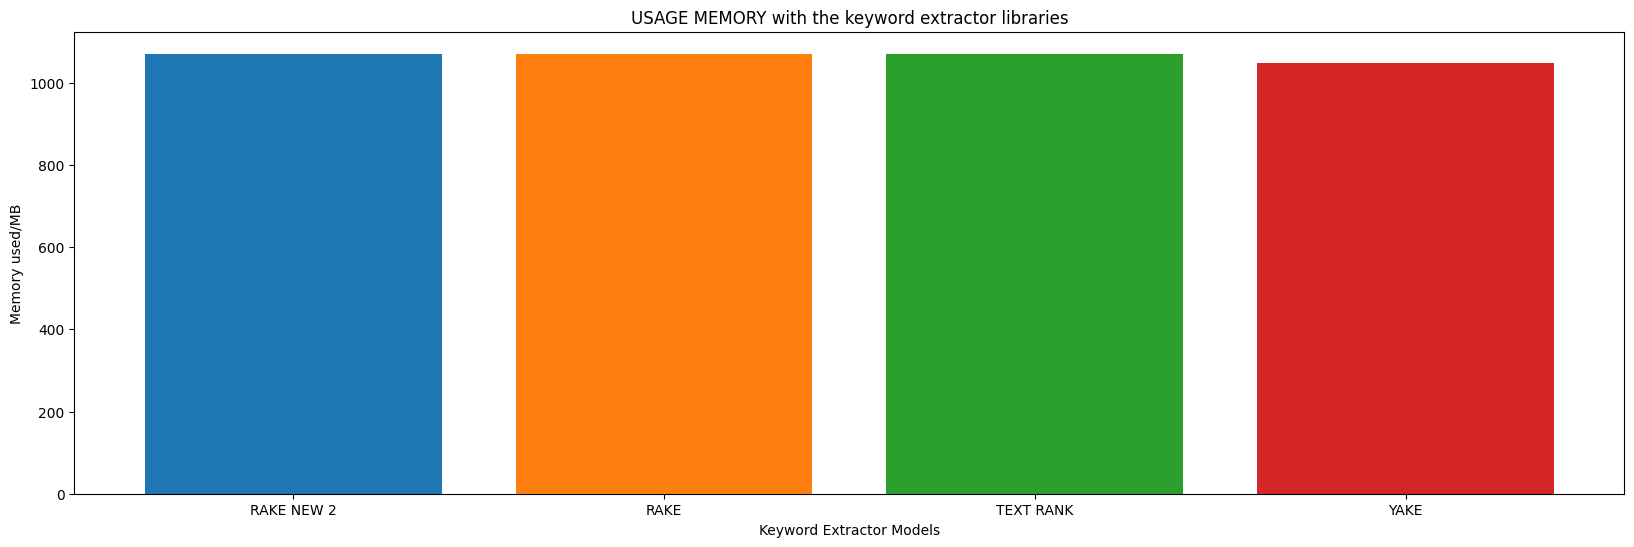

In [ ]:
import matplotlib.pyplot as plt

# Plot the results
plt.figure(figsize=(20, 6))

for threshold, question_count in [('RAKE NEW 2', memory_usage2),
                                  ('RAKE', memory_usage3),
                                  ('TEXT RANK', memory_usage4),
                                  ('YAKE', memory_usage1),
                                 ]:
    plt.bar(str(threshold), question_count)

plt.xlabel('Keyword Extractor Models')
plt.ylabel('Memory used/MB')
plt.title('USAGE MEMORY with the keyword extractor libraries')
plt.show()

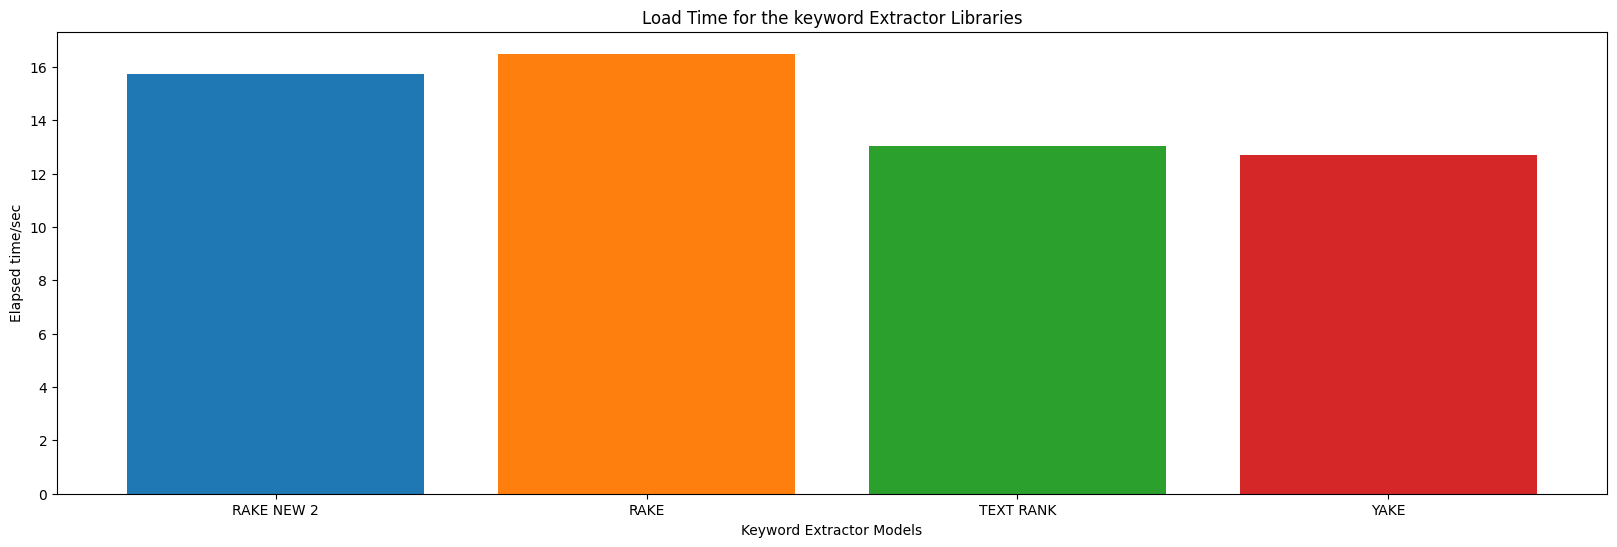

In [ ]:
import matplotlib.pyplot as plt

# Plot the results
plt.figure(figsize=(20, 6))

for threshold, question_count in [('RAKE NEW 2', elapsed_time_rakenew2),
                                  ('RAKE', elapsed_time_rake),
                                  ('TEXT RANK', elapsed_time_textrake),
                                  ('YAKE', elapsed_time_doc2vec),
                                  # (token_threshold_1, trial1_threshold_count_2000_question),
                                  # Add more pairs here for additional trials
                                 ]:
    plt.bar(str(threshold), question_count)

plt.xlabel('Keyword Extractor Models')
plt.ylabel('Elapsed time/sec')
plt.title('Load Time for the keyword Extractor Libraries')
plt.show()

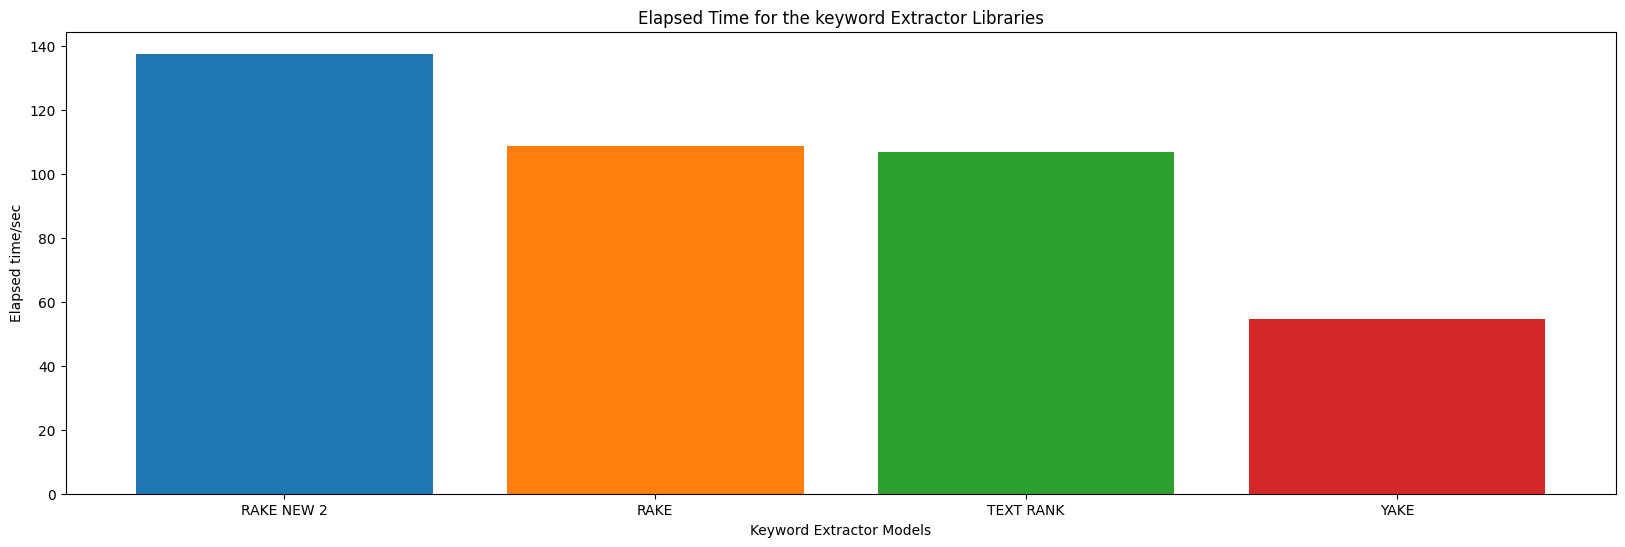

In [ ]:
import matplotlib.pyplot as plt

# Plot the results
plt.figure(figsize=(20, 6))

for threshold, question_count in [('RAKE NEW 2', elapsed_time2),
                                  ('RAKE', elapsed_time3),
                                  ('TEXT RANK', elapsed_time4),
                                  ('YAKE', elapsed_time1),
                                 ]:
    plt.bar(str(threshold), question_count)

plt.xlabel('Keyword Extractor Models')
plt.ylabel('Elapsed time/sec')
plt.title('Elapsed Time for the keyword Extractor Libraries')
plt.show()

* All of the libraries almost gave the same keywords  
* We found that the load time and the time elapsed (in the store and the keyword compare functions ) is decreased with the YAKE library

* So, we will use YAKE library with (doc2vec,500 threshold)

# **Here, we will try different summarization libraries**

#LEXRANK

In [ ]:
# Set the URL of the PDF you want to work with
pdf_url = "https://www.cell.com/the-innovation/pdf/S2666-6758(20)30036-9.pdf"
# Initialize the Words_Digest with the PDF URL
first_approch = First_approach(pdf_url)
pdf_info = first_approch.kw_emb_store(extract_keywords_yake,generate_emb_doc_2_vec,create_embedding_ada)
# Create a list of indices from the stored PDF info
indices_only = [info[0] for info in pdf_info]
# Initialize conversation history
conversation_history = []
start_time5 = time.time()
# Set token and similarity thresholds
token_threshold = 500
similarity_threshold = 0.8

while True:
    try:
        user_prompt = input("You: ")

        if user_prompt.lower() == "exit":
            break
        # Find similar paragraph indices based on user input and similarity threshold
        similar_paragraph_indices = first_approch.keyword_compare(user_prompt,create_embedding_ada,extract_keywords_yake, similarity_threshold=similarity_threshold)
        print ('similar_paragraph_indices:',similar_paragraph_indices)
        if len(similar_paragraph_indices) == 0:
          # Use all paragraph indices when no similar ones are found
            similar_paragraph_indices=indices_only
            # Get the top indices based on embeddings comparison
            top_indices = first_approch.embeddings_compare(similar_paragraph_indices, user_prompt, embedding_function=generate_emb_doc_2_vec)
            print ('top_indices:',top_indices)
            if len(top_indices) == 0:
              print('The answer to this question is not provided in this PDF')
              continue
            else:
              # Generate a summary and prompt for GPT-3
              summary = first_approch.tokens_check_and_summerization(user_prompt, top_indices, lexrank, token_threshold=token_threshold)
              prompt = first_approch.prompt_generator(user_prompt, summary)
              conversation_history.append({"role": "user", "content": prompt})
               # Generate a response from GPT-3
              response = first_approch.run_chatgpt(conversation_history)
              print("Assistant's Response:", response)
               # Calculate similarity percentage
              similarity_percentage = first_approch.evaluation(summary, response,embedding_function=generate_emb_sbert)
              conversation_history.append({"role": "assistant", "content": response})

        else:
          # Get the top indices based on embeddings comparison
            top_indices = first_approch.embeddings_compare(similar_paragraph_indices, user_prompt, embedding_function=generate_emb_doc_2_vec)
            print ('top_indices:',top_indices)
            # Generate a summary and prompt for GPT-3
            summary = first_approch.tokens_check_and_summerization(user_prompt, top_indices, lexrank, token_threshold=token_threshold)
            prompt = first_approch.prompt_generator(user_prompt, summary)
            conversation_history.append({"role": "user", "content": prompt})
             # Generate a response from GPT-3
            response = first_approch.run_chatgpt(conversation_history)
            print("Assistant's Response:", response)
             # Calculate similarity percentage
            similarity_percentage = first_approch.evaluation(summary, response, embedding_function=generate_emb_sbert)
            conversation_history.append({"role": "assistant", "content": response})

    except openai.error.InvalidRequestError as e:
        print("Error:", e)
        print("Total token count exceeded. Exiting...")
        break

# Measure elapsed time
end_time5 = time.time()
elapsed_time5 = end_time5 - start_time5
print("Elapsed Time:", elapsed_time5, "seconds")

# Measure memory usage
process5 = psutil.Process()
memory_usage5 = process5.memory_info().rss / (1024 * 1024)  # in MB
print("Memory Usage:", memory_usage5, "MB")

#What are the main scientific and technical challenges involved in Mars exploration and potential human migration to Mars?
#What scientific themes and specific issues are addressed in Mars exploration missions?
#How does the Mars exploration shift from focusing on the Moon to considering Mars as a potential destination for humanity?
# How many missions had done in 2020?
# What will Perseverance rover do?
# What is Hope?
# What were the three sequential Mars exploration missions in 2020?

You: What are the main scientific and technical challenges involved in Mars exploration and potential human migration to Mars?
similar_paragraph_indices: [4, 5, 7, 8, 12]
top_indices: [5, 8, 7, 4, 12]
Ratio between token_size_summary and token_size_paragraph: 48.17987152034261
Assistant's Response: The main scientific and technical challenges involved in Mars exploration and potential human migration to Mars include:

1) Developing the necessary technology: The development of advanced technologies and systems that can withstand the extreme conditions on Mars, such as the thin atmosphere, low gravity, and harsh temperatures, is a major challenge. This includes developing reliable life support systems, navigation systems, and communication infrastructure.

2) Landing on Mars: Landing a spacecraft safely on Mars is a complex task due to its thin atmosphere and the need for precise navigation and descent. The entry, descent, and landing (EDL) phase is crucial and requires innovative soluti

#LUHN

In [ ]:
# Set the URL of the PDF you want to work with
first_approch = First_approach(pdf_url)
# Initialize the Words_Digest with the PDF URL
pdf_info = first_approch.kw_emb_store(extract_keywords_yake,generate_emb_doc_2_vec,create_embedding_ada)
# Create a list of indices from the stored PDF info
indices_only = [info[0] for info in pdf_info]
# Initialize conversation history
conversation_history = []
start_time6 = time.time()
# Set token and similarity thresholds
token_threshold = 500
similarity_threshold = 0.8

while True:
    try:
        user_prompt = input("You: ")

        if user_prompt.lower() == "exit":
            break
        # Find similar paragraph indices based on user input and similarity threshold
        similar_paragraph_indices = first_approch.keyword_compare(user_prompt,create_embedding_ada,extract_keywords_yake, similarity_threshold=similarity_threshold)
        print ('similar_paragraph_indices:',similar_paragraph_indices)
        if len(similar_paragraph_indices) == 0:
          # Use all paragraph indices when no similar ones are found
            similar_paragraph_indices=indices_only
             # Get the top indices based on embeddings comparison
            top_indices = first_approch.embeddings_compare(similar_paragraph_indices, user_prompt, embedding_function=generate_emb_doc_2_vec)
            print ('top_indices:',top_indices)
            if len(top_indices) == 0:
              print('The answer to this question is not provided in this PDF')
              continue
            else:
              # Generate a summary and prompt for GPT-3
              summary = first_approch.tokens_check_and_summerization(user_prompt, top_indices, luhn, token_threshold=token_threshold)
              prompt = first_approch.prompt_generator(user_prompt, summary)
              conversation_history.append({"role": "user", "content": prompt})
               # Generate a response from GPT-3
              response = first_approch.run_chatgpt(conversation_history)
              print("Assistant's Response:", response)
               # Calculate similarity percentage
              similarity_percentage = first_approch.evaluation(summary, response,embedding_function=generate_emb_sbert)
              conversation_history.append({"role": "assistant", "content": response})

        else:
          # Get the top indices based on embeddings comparison
            top_indices = first_approch.embeddings_compare(similar_paragraph_indices, user_prompt, embedding_function=generate_emb_doc_2_vec)
            print ('top_indices:',top_indices)
            # Generate a summary and prompt for GPT-3
            summary = first_approch.tokens_check_and_summerization(user_prompt, top_indices, luhn, token_threshold=token_threshold)
            prompt = first_approch.prompt_generator(user_prompt, summary)
            conversation_history.append({"role": "user", "content": prompt})
             # Generate a response from GPT-3
            response = first_approch.run_chatgpt(conversation_history)
            print("Assistant's Response:", response)
             # Calculate similarity percentage
            similarity_percentage = first_approch.evaluation(summary, response, embedding_function=generate_emb_sbert)
            conversation_history.append({"role": "assistant", "content": response})

    except openai.error.InvalidRequestError as e:
        print("Error:", e)
        print("Total token count exceeded. Exiting...")
        break

# Measure elapsed time
end_time6 = time.time()
elapsed_time6 = end_time6 - start_time6
print("Elapsed Time:", elapsed_time6, "seconds")

# Measure memory usage
process6 = psutil.Process()
memory_usage6 = process6.memory_info().rss / (1024 * 1024)  # in MB
print("Memory Usage:", memory_usage6, "MB")

#What are the main scientific and technical challenges involved in Mars exploration and potential human migration to Mars?
#What scientific themes and specific issues are addressed in Mars exploration missions?
#How does the Mars exploration shift from focusing on the Moon to considering Mars as a potential destination for humanity?
# How many missions had done in 2020?
# What will Perseverance rover do?
# What is Hope?
# What were the three sequential Mars exploration missions in 2020?

You: What are the main scientific and technical challenges involved in Mars exploration and potential human migration to Mars?
similar_paragraph_indices: [4, 5, 7, 8, 12]
top_indices: [5, 8, 7, 4, 12]
Ratio between token_size_summary and token_size_paragraph: 48.17987152034261
Assistant's Response: The main scientific and technical challenges involved in Mars exploration and potential human migration to Mars include:

1. Landing on Mars: Landing a spacecraft on Mars is a complex and challenging task due to the planet's thin atmosphere, which makes it difficult to slow down a spacecraft during descent. This challenge requires the development of advanced landing technologies and precise navigation systems.

2. Sustainability and resource utilization: In order for humans to survive and thrive on Mars, they would need to establish sustainable habitats and utilize the available resources on the planet. This includes finding ways to generate power, produce food, extract water, and manage was

#Plot the memory usage and the time elapsed

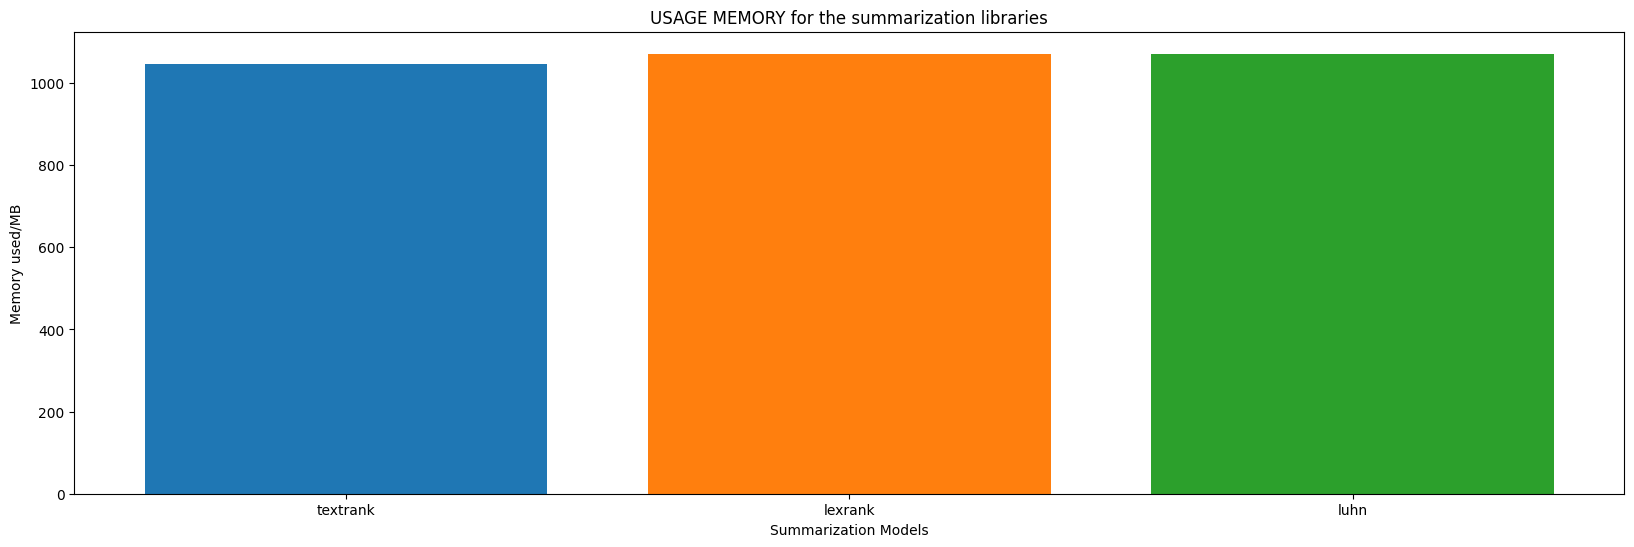

In [ ]:
import matplotlib.pyplot as plt

# Plot the results
plt.figure(figsize=(20, 6))

for threshold, question_count in [('textrank', memory_usage1),
                                  ('lexrank', memory_usage5),
                                  ('luhn', memory_usage6),
                                 ]:
    plt.bar(str(threshold), question_count)

plt.xlabel('Summarization Models')
plt.ylabel('Memory used/MB')
plt.title('USAGE MEMORY for the summarization libraries')
plt.show()


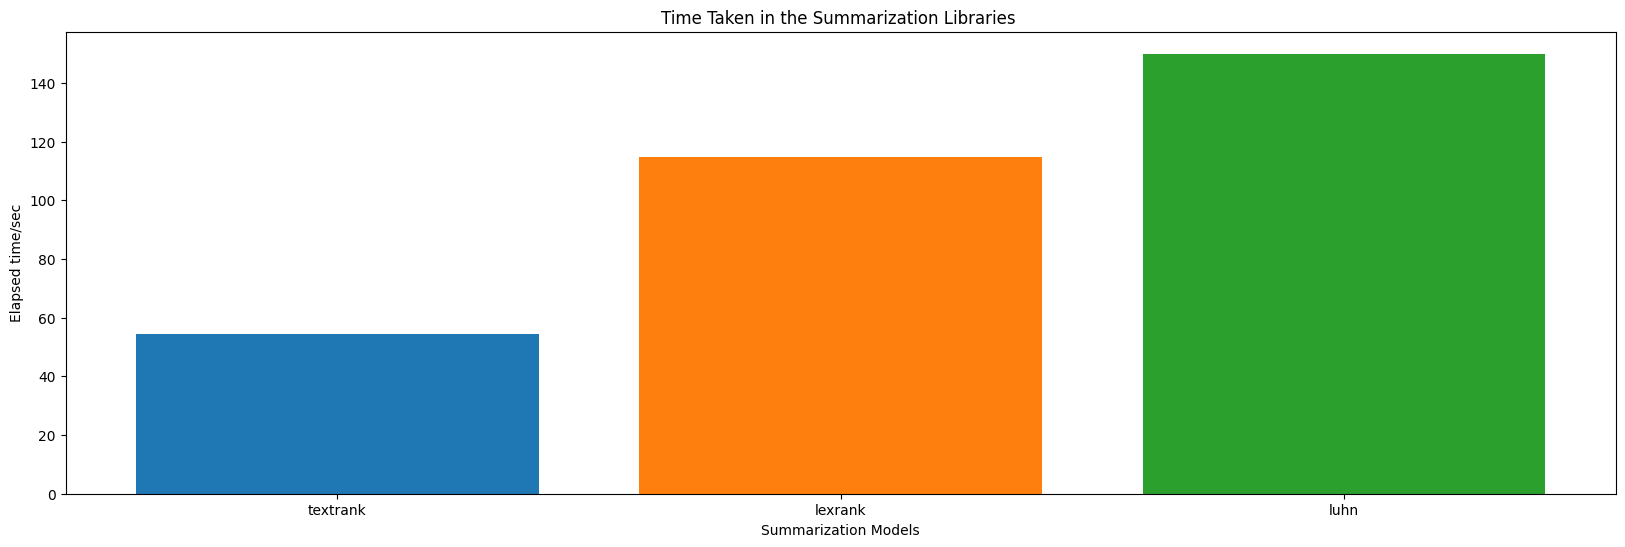

In [ ]:
import matplotlib.pyplot as plt

# Plot the results
plt.figure(figsize=(20, 6))

for threshold, question_count in [('textrank', elapsed_time1),
                                  ('lexrank', elapsed_time5),
                                  ('luhn', elapsed_time6),
                                 ]:
    plt.bar(str(threshold), question_count)

plt.xlabel('Summarization Models')
plt.ylabel('Elapsed time/sec')
plt.title('Time Taken in the Summarization Libraries')
plt.show()

* Textrank and Lexrank gave better summarization than luhn
* We are confused between them, so we will use the time to be able to choose
* We found that the memory usage for the libraries is almost the same
* While time of the "textrank" is lower
* So, we will complete with the textrank (with doc2vec,500 threshold, yake)

# **We will try different word embeddings on the keywords**

#DAVINCI

In [ ]:
# Set the URL of the PDF you want to work with
pdf_url = "https://www.cell.com/the-innovation/pdf/S2666-6758(20)30036-9.pdf"
# Initialize the Words_Digest with the PDF URL
first_approch = First_approach(pdf_url)
# Measure the time it takes to store keyword embeddings
start_time_davinci = time.time()
pdf_info = first_approch.kw_emb_store(extract_keywords_yake,generate_emb_doc_2_vec,create_embedding_davinci)
end_time_davinci = time.time()
elapsed_time_davinci= end_time_davinci - start_time_davinci
print("Elapsed Time for store with the word embeddding (davinci):", elapsed_time_davinci, "seconds")

Elapsed Time for store with the word embeddding (davinci): 15.81173300743103 seconds


In [ ]:
# Set token and similarity thresholds
token_threshold = 500
similarity_threshold = 0.8
# Create a list of indices from the stored PDF info
indices_only = [info[0] for info in pdf_info]
# Initialize conversation history
conversation_history = []
# Start measuring time for the main loop
start_time7 = time.time()

while True:
    try:
        user_prompt = input("You: ")

        if user_prompt.lower() == "exit":
            break
         # Find similar paragraph indices based on user input and similarity threshold
        similar_paragraph_indices = first_approch.keyword_compare(user_prompt,create_embedding_davinci,extract_keywords_yake, similarity_threshold=similarity_threshold)
        print ('similar_paragraph_indices:',similar_paragraph_indices)
        if len(similar_paragraph_indices) == 0:
          # Use all paragraph indices when no similar ones are found
            similar_paragraph_indices=indices_only
            # Get the top indices based on embeddings comparison
            top_indices = first_approch.embeddings_compare(similar_paragraph_indices, user_prompt, embedding_function=generate_emb_doc_2_vec)
            print ('top_indices:',top_indices)
            if len(top_indices) == 0:
              print('The answer to this question is not provided in this PDF')
              continue
            else:
              # Generate a summary and prompt for GPT-3
              summary = first_approch.tokens_check_and_summerization(user_prompt, top_indices, textrank, token_threshold=token_threshold)
              prompt = first_approch.prompt_generator(user_prompt, summary)
              conversation_history.append({"role": "user", "content": prompt})
              # Generate a response from GPT-3
              response = first_approch.run_chatgpt(conversation_history)
              print("Assistant's Response:", response)
              # Calculate similarity percentage
              similarity_percentage = first_approch.evaluation(summary, response,embedding_function=generate_emb_sbert)
              conversation_history.append({"role": "assistant", "content": response})

        else:
          # Get the top indices based on embeddings comparison
            top_indices = first_approch.embeddings_compare(similar_paragraph_indices, user_prompt, embedding_function=generate_emb_doc_2_vec)
            print ('top_indices:',top_indices)
            # Generate a summary and prompt for GPT-3
            summary = first_approch.tokens_check_and_summerization(user_prompt, top_indices, textrank, token_threshold=token_threshold)
            prompt = first_approch.prompt_generator(user_prompt, summary)
            conversation_history.append({"role": "user", "content": prompt})
            # Generate a response from GPT-3
            response = first_approch.run_chatgpt(conversation_history)
            print("Assistant's Response:", response)
            # Calculate similarity percentage
            similarity_percentage = first_approch.evaluation(summary, response, embedding_function=generate_emb_sbert)
            conversation_history.append({"role": "assistant", "content": response})

    except openai.error.InvalidRequestError as e:
        print("Error:", e)
        print("Total token count exceeded. Exiting...")
        break

# Measure elapsed time
end_time7 = time.time()
elapsed_time7 = end_time7 - start_time7
print("Elapsed Time:", elapsed_time7, "seconds")

# Measure memory usage
process7 = psutil.Process()
memory_usage7 = process7.memory_info().rss / (1024 * 1024)  # in MB
print("Memory Usage:", memory_usage7, "MB")

#What are the main scientific and technical challenges involved in Mars exploration and potential human migration to Mars?
#What scientific themes and specific issues are addressed in Mars exploration missions?
#How does the Mars exploration shift from focusing on the Moon to considering Mars as a potential destination for humanity?
# How many missions had done in 2020?
# What will Perseverance rover do?
# What is Hope?
# What were the three sequential Mars exploration missions in 2020?

You: What are the main scientific and technical challenges involved in Mars exploration and potential human migration to Mars?
similar_paragraph_indices: [4, 5, 7, 8, 12]
top_indices: [5, 8, 7, 4, 12]
Ratio between token_size_summary and token_size_paragraph: 48.17987152034261
Assistant's Response: The main scientific challenges involved in Mars exploration and potential human migration to Mars include:

1. Searching for signs of ancient microbial life: One of the primary goals of Mars exploration is to search for evidence of past or present microbial life on the planet. This requires advanced scientific instruments and techniques to analyze the Martian soil and rock samples.

2. Understanding the geological history and surface conditions: Mars has a complex geological history, and understanding its composition, rock formations, and past climate is crucial for determining its potential habitability. This requires detailed remote sensing surveys and in-depth investigations of specific a

#Plot the memory usage , loaded time and the time elapsed

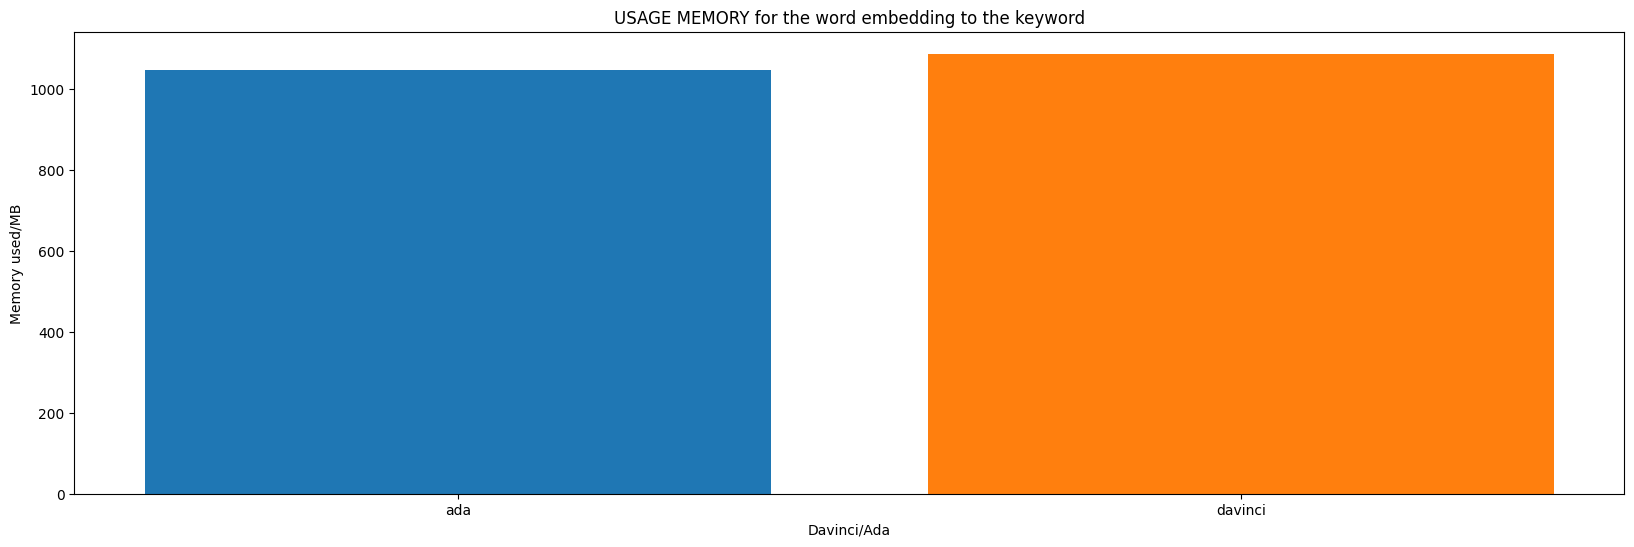

In [ ]:
import matplotlib.pyplot as plt

# Plot the results
plt.figure(figsize=(20, 6))

for threshold, question_count in [('ada', memory_usage1),
                                  ('davinci', memory_usage7),
                                 ]:
    plt.bar(str(threshold), question_count)

plt.xlabel('Davinci/Ada')
plt.ylabel('Memory used/MB')
plt.title('USAGE MEMORY for the word embedding to the keyword')
plt.show()


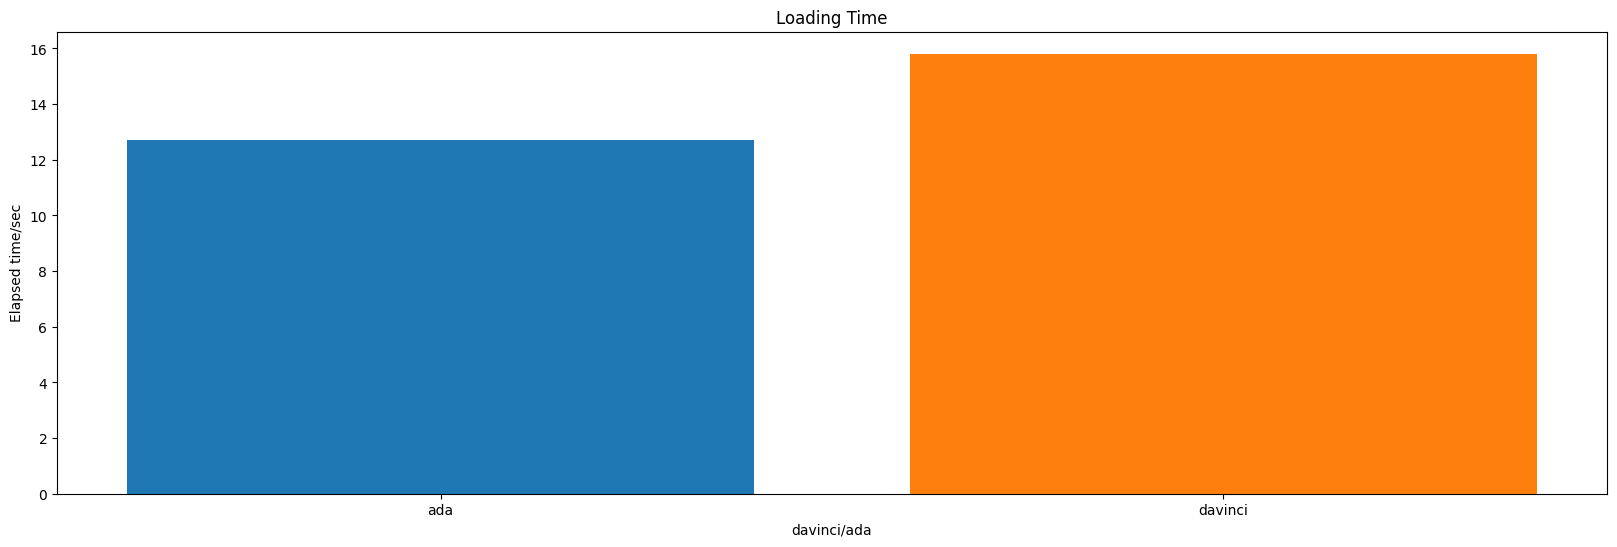

In [ ]:
import matplotlib.pyplot as plt

# Plot the results
plt.figure(figsize=(20, 6))

for threshold, question_count in [('ada', elapsed_time_doc2vec),
                                  ('davinci', elapsed_time_davinci),
                                 ]:
    plt.bar(str(threshold), question_count)

plt.xlabel('davinci/ada')
plt.ylabel('Elapsed time/sec')
plt.title('Loading Time')
plt.show()

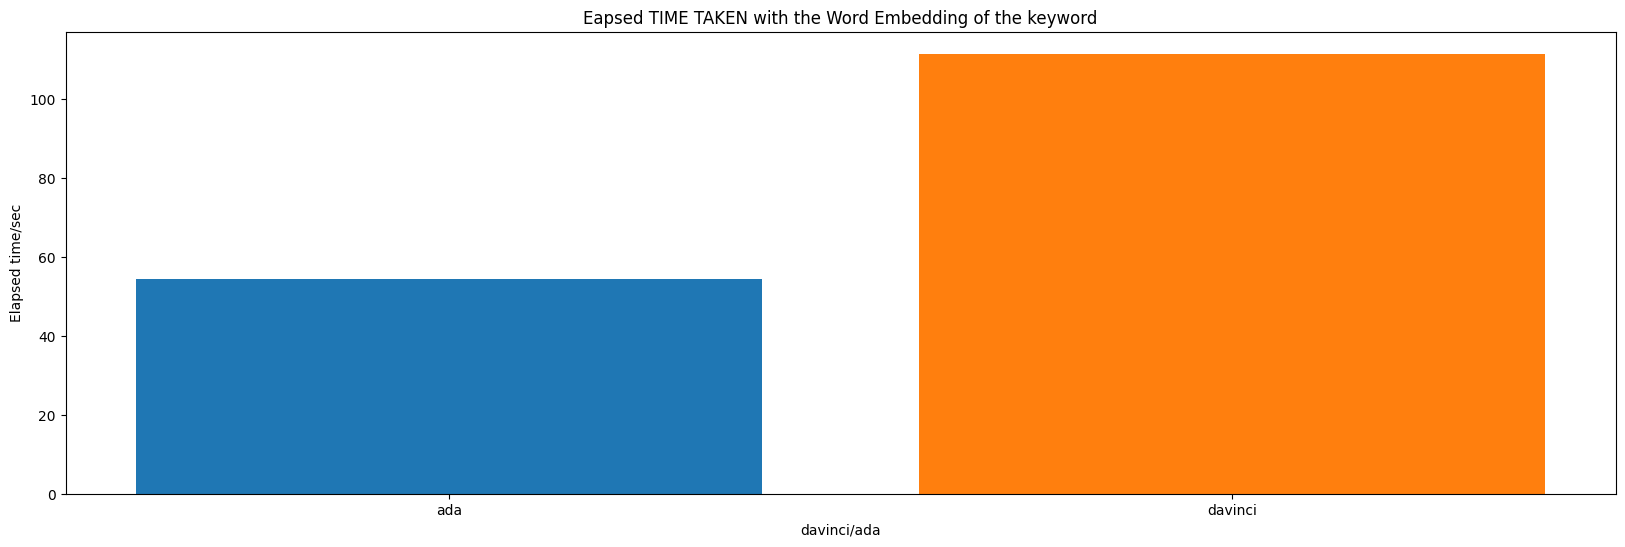

In [ ]:
import matplotlib.pyplot as plt

# Plot the results
plt.figure(figsize=(20, 6))

for threshold, question_count in [('ada', elapsed_time1),
                                  ('davinci', elapsed_time7),
                                 ]:
    plt.bar(str(threshold), question_count)

plt.xlabel('davinci/ada')
plt.ylabel('Elapsed time/sec')
plt.title('Eapsed TIME TAKEN with the Word Embedding of the keyword')
plt.show()

* We just tried davinci and ada as a word embedding with keywords
* The best response was with ada
* Both of them almost took the same memory usage
* Also, ada takes less time in load and elapsing than davinci
* We will complete with ada (with doc2vec, threshold=500, yake, textrank)

#**Try with and without applying keyword on it**

In [ ]:
# Set the URL of the PDF you want to work with
pdf_url = "https://www.cell.com/the-innovation/pdf/S2666-6758(20)30036-9.pdf"
#  Initialize the Words_Digest with the PDF URL
first_approch = First_approach(pdf_url)
pdf_info = first_approch.kw_emb_store(extract_keywords_yake,generate_emb_doc_2_vec,create_embedding_ada)
# Create a list of indices from the stored PDF info
indices_only = [info[0] for info in pdf_info]
# Initialize conversation history
conversation_history = []
# Start measuring time for the main loop
start_time8 = time.time()
# Set token and similarity thresholds
token_threshold=500
similarity_threshold=0.8
while True:
    try:
        user_prompt = input("You: ")

        if user_prompt.lower() == "exit":
            break
        # Get the top indices based on embeddings comparison
        top_indices = first_approch.embeddings_compare(indices_only, user_prompt, embedding_function=generate_emb_doc_2_vec)
        # Generate a summary and prompt for GPT-3
        summary = first_approch.tokens_check_and_summerization(user_prompt, top_indices, textrank, token_threshold=token_threshold)
        prompt = first_approch.prompt_generator(user_prompt, summary)
        conversation_history.append({"role": "user", "content": prompt})
        # Generate a response from GPT-3
        response = first_approch.run_chatgpt(conversation_history)
        print("Assistant's Response:", response)
        # Calculate similarity percentage
        similarity_percentage = first_approch.evaluation(summary, response, generate_emb_sbert)
        conversation_history.append({"role": "assistant", "content": response})

    except openai.error.InvalidRequestError as e:
        print("Error:", e)
        print("Total token count exceeded. Exiting...")
        break

# Measure elapsed time
end_time8 = time.time()
elapsed_time8= end_time8 - start_time8
print("Elapsed Time:", elapsed_time8, "seconds")

# Measure memory usage
process8 = psutil.Process()
memory_usage8 = process8.memory_info().rss / (1024 * 1024)  # in MB
print("Memory Usage:", memory_usage8, "MB")
#What are the main scientific and technical challenges involved in Mars exploration and potential human migration to Mars?
#What scientific themes and specific issues are addressed in Mars exploration missions?
#How does the Mars exploration shift from focusing on the Moon to considering Mars as a potential destination for humanity?
# How many missions had done in 2020?
# What will Perseverance rover do?
# What is Hope?
# What were the three sequential Mars exploration missions in 2020?

You: What are the main scientific and technical challenges involved in Mars exploration and potential human migration to Mars?
Ratio between token_size_summary and token_size_paragraph: 47.071129707112966
Assistant's Response: The main scientific and technical challenges involved in Mars exploration and potential human migration to Mars include:

1. Landing on Mars: Landing a spacecraft on Mars is a complex and risky endeavor due to the thin Martian atmosphere and the need for precise and controlled descent and landing.

2. Limited resources: Mars lacks the readily available resources that are necessary for sustaining human life, such as food, water, and breathable air. Developing technologies to generate these resources on Mars or efficiently transporting them from Earth is a significant challenge.

3. Extreme environment: Mars has a harsh environment with extreme cold temperatures, high levels of radiation, dust storms, and low atmospheric pressure. Developing technologies to protect

#Plot the memory usage and the time elapsed

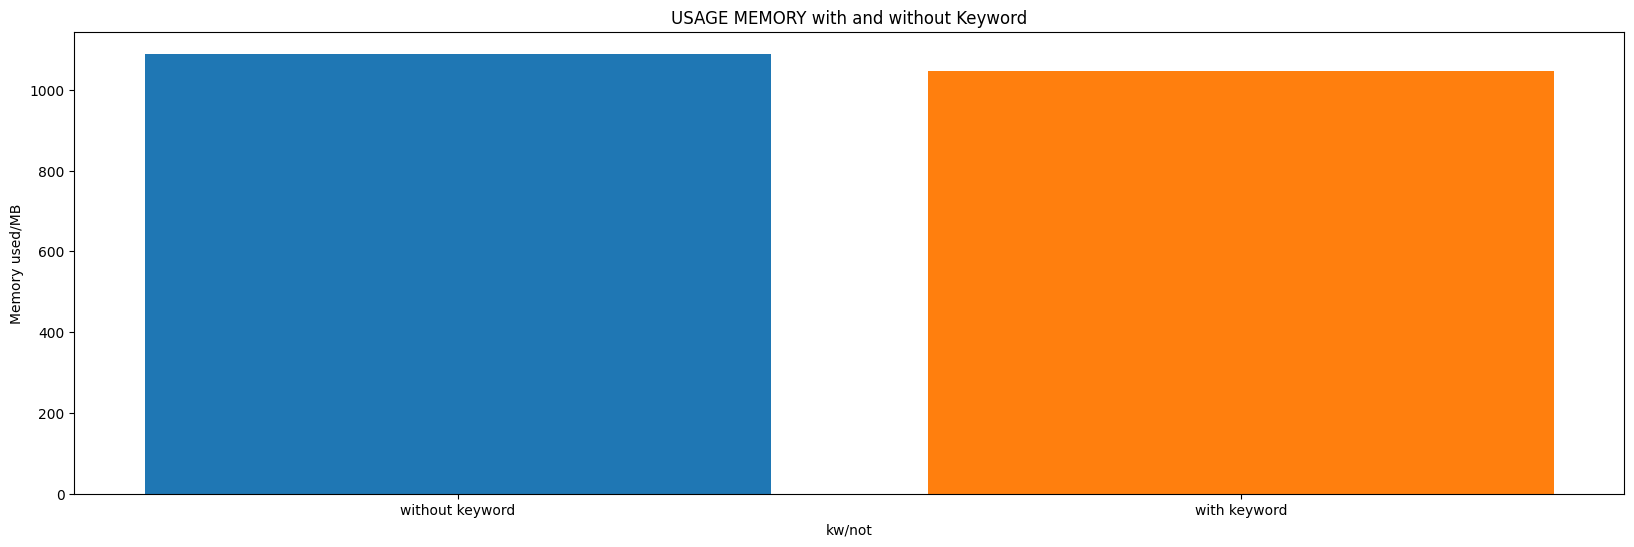

In [ ]:
import matplotlib.pyplot as plt

# Plot the results
plt.figure(figsize=(20, 6))

for threshold, question_count in [('without keyword', memory_usage8),
                                  ('with keyword', memory_usage1),
                                 ]:
    plt.bar(str(threshold), question_count)

plt.xlabel('kw/not')
plt.ylabel('Memory used/MB')
plt.title('USAGE MEMORY with and without Keyword')
plt.show()


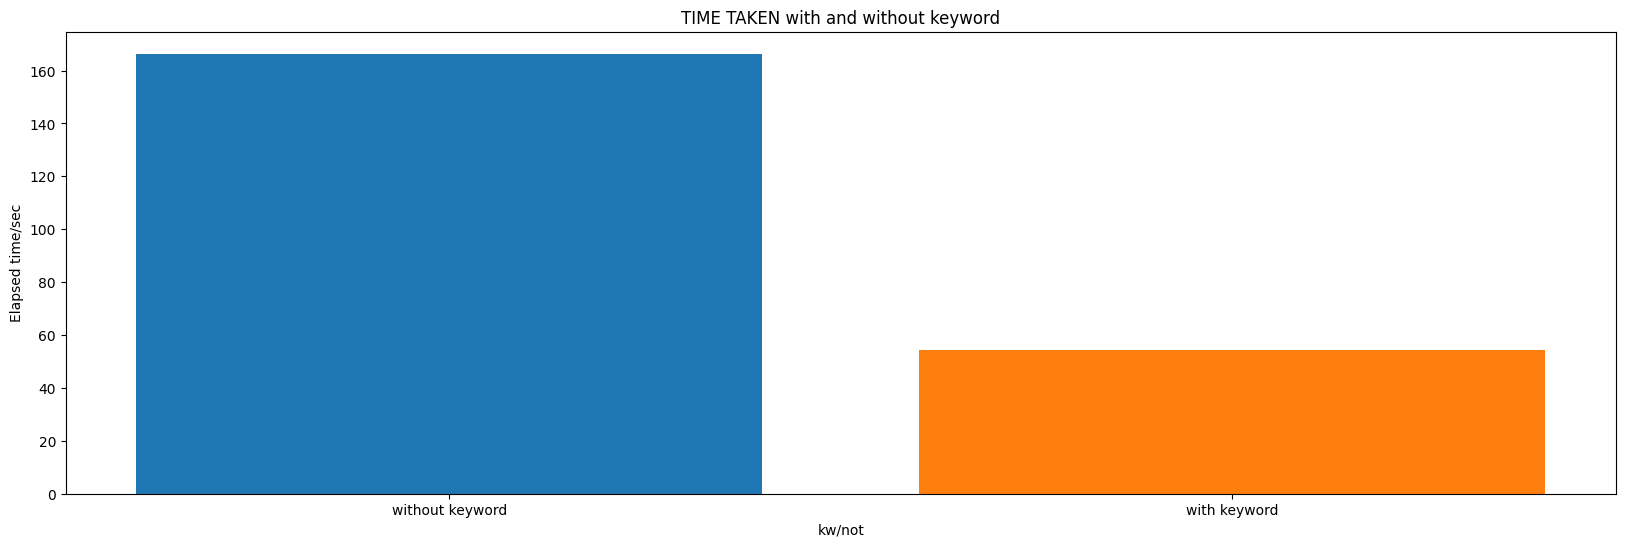

In [ ]:
import matplotlib.pyplot as plt

# Plot the results
plt.figure(figsize=(20, 6))

for threshold, question_count in [('without keyword', elapsed_time8),
                                  ('with keyword', elapsed_time1),
                                 ]:
    plt.bar(str(threshold), question_count)

plt.xlabel('kw/not')
plt.ylabel('Elapsed time/sec')
plt.title('TIME TAKEN with and without keyword')
plt.show()

* We did this trial to see , whether it is better with the keyword or not
* We found that the response with the keyword is much better than without keyword
* The memory usage is almost the same for both of them
* Also, the time taken in "with keyword" is less than "without keyword"
* So, we will complete with keywords (with ada, doc2vec,500 threshold, yake, textrank)

# **We will try new PDF**

We tried 2 different pdfs with different sizes and also we gave it 3 questions and will compare the answers of the gpt with the true answers to see the similarity between them


# pdf = 'https://openaccess.thecvf.com/content/CVPR2022/papers/Zhai_Scaling_Vision_Transformers_CVPR_2022_paper.pdf'

10 pages with 6478 tokens

3 questions and evaluate the response with the true answers


# With DOC2VEC

In [ ]:
# Calculate similarity percentage
pdf_url = 'https://openaccess.thecvf.com/content/CVPR2022/papers/Zhai_Scaling_Vision_Transformers_CVPR_2022_paper.pdf'
# Initialize the Words_Digest with the PDF URL
first_approch = First_approach(pdf_url)
# Measure the time it takes to
start_time_10 = time.time()
pdf_info = first_approch.kw_emb_store(extract_keywords_yake,generate_emb_doc_2_vec,create_embedding_ada)
end_time_10 = time.time()
elapsed_time_10= end_time_10 - start_time_10
print("Elapsed Time for store with the embeddding sentence (doc2vec):", elapsed_time_10, "seconds")

Elapsed Time for store with the embeddding sentence (doc2vec): 86.71086812019348 seconds


In [ ]:
# Set token and similarity thresholds
token_threshold = 500
similarity_threshold = 0.8
# Create a list of indices from the stored PDF info
indices_only = [info[0] for info in pdf_info]
# Initialize conversation history
conversation_history = []
# Start measuring time for the main loop
start_time10 = time.time()
# This is the true answers of the questions
ans1=['The findings include: performance follows a power-law with respect to compute and data size, larger models show improved few-shot transfer, optimizations like half-precision momentum and memory-efficient training enhance efficiency, and scaling up data along with model size improves overall performance, culminating in a new state-of-the-art model.',
      'The paper contributes by providing insights into how ViT models scale in terms of performance, compute, and data. It highlights the importance of properly scaling both model size and compute resources to achieve optimal results. The study also introduces practical techniques for enhancing the training and transfer capabilities of ViT models, which can guide the design and development of future large-scale vision models.',
      'The paper presents several key findings and improvements related to the scaling properties of Vision Transformers (ViTs). Some of the main findings are:Scaling Laws: The study demonstrates that the performance of ViT models follows a power-law relationship with respect to compute, model size, and data size. Larger models perform better, and scaling up compute and data together improves representation quality. However, there is a saturation effect observed at both high and low ends of the compute spectrum.Few-Shot Transfer: Larger ViT models exhibit better few-shot transfer performance. The study shows that bigger models are more sample efficient, achieving the same level of error rate with fewer seen images. This indicates that training a larger model for fewer steps is preferable, mirroring results from language modeling and machine translation.Optimizations: The paper introduces various optimizations to improve the training and memory efficiency of ViT models. These include using half-precision momentum for memory savings, removing the [class] token and using global average pooling or multihead attention pooling for memory efficiency, and employing memory-efficient optimizers like AdaFactor.Scaling Up Data: The study uses the JFT-3B dataset, a larger version of JFT-300M, which significantly improves the quality of the model even before scaling up its size. This demonstrates that the dataset quality and size play a crucial role in performance.State-of-the-Art Model: The paper successfully trains a ViT model with two billion parameters (ViT-G/14) and achieves a new state-of-the-art top-1 accuracy of 90.45% on the ImageNet benchmark. This model also performs well for few-shot transfer tasks, reaching 84.86% top-1 accuracy on ImageNet with only 10 examples per class.In summary, the paper highlights the importance of scaling laws in designing high-performing ViT models, emphasizes the benefits of larger models for few-shot transfer, introduces memory-efficient optimizations, and demonstrates the effectiveness of a large ViT-G/14 model in achieving new state-of-the-art results on ImageNet.']
res1=[]
sim_per1=[]

for i in range(len(ans1)):
    try:
        user_prompt = input("You: ")

        if user_prompt.lower() == "exit":
            break
        # Find similar paragraph indices based on user input and similarity threshold
        similar_paragraph_indices = first_approch.keyword_compare(user_prompt,create_embedding_ada,extract_keywords_yake, similarity_threshold=similarity_threshold)
        print ('similar_paragraph_indices:',similar_paragraph_indices)
        if len(similar_paragraph_indices) == 0:
          # Use all paragraph indices when no similar ones are found
            similar_paragraph_indices=indices_only
            # Get the top indices based on embeddings comparison
            top_indices = first_approch.embeddings_compare(similar_paragraph_indices, user_prompt, embedding_function=generate_emb_doc_2_vec)
            print ('top_indices:',top_indices)
            if len(top_indices) == 0:
              print('The answer to this question is not provided in this PDF')
              continue
            else:
              # Generate a summary and prompt for GPT-3
              summary = first_approch.tokens_check_and_summerization(user_prompt, top_indices, textrank, token_threshold=token_threshold)
              prompt = first_approch.prompt_generator(user_prompt, summary)
              conversation_history.append({"role": "user", "content": prompt})
              # Generate a response from GPT-3
              response = first_approch.run_chatgpt(conversation_history)
              res1.append(response)
              print("Assistant's Response:", response)
              # Calculate similarity percentage
              similarity_percentage = first_approch.evaluation(ans1[i], response, generate_emb_sbert)
              sim_per1.append(similarity_percentage)
              print("Similarity Percentage:", similarity_percentage)
              conversation_history.append({"role": "assistant", "content": response})

        else:
            #  Get the top indices based on embeddings comparison
            top_indices = first_approch.embeddings_compare(similar_paragraph_indices, user_prompt, embedding_function=generate_emb_doc_2_vec)
            print ('top_indices:',top_indices)
            # Generate a summary and prompt for GPT-3
            summary = first_approch.tokens_check_and_summerization(user_prompt, top_indices, textrank, token_threshold=token_threshold)
            prompt = first_approch.prompt_generator(user_prompt, summary)
            conversation_history.append({"role": "user", "content": prompt})
            # Generate a response from GPT-3
            response = first_approch.run_chatgpt(conversation_history)
            res1.append(response)
            print("Assistant's Response:", response)
            # Calculate similarity percentage
            similarity_percentage = first_approch.evaluation(ans1[i], response, generate_emb_sbert)
            sim_per1.append(similarity_percentage)
            print("Similarity Percentage:", similarity_percentage)
            conversation_history.append({"role": "assistant", "content": response})

    except openai.error.InvalidRequestError as e:
        print("Error:", e)
        print("Total token count exceeded. Exiting...")
        break

# Measure elapsed time
end_time10 = time.time()
elapsed_time10 = end_time10 - start_time10
print("Elapsed Time:", elapsed_time10, "seconds")

# Measure memory usage
process10 = psutil.Process()
memory_usage10 = process10.memory_info().rss / (1024 * 1024)  # in MB
print("Memory Usage:", memory_usage10, "MB")

# What are the main findings regarding the performance of Vision Transformers (ViTs) when it comes to scaling properties?in points
# How does the paper contribute to the field of computer vision? in points
# What are some key findings and improvements discussed in the paper regarding the scaling properties of Vision Transformers (ViTs)?in points

You: What are the main findings regarding the performance of Vision Transformers (ViTs) when it comes to scaling properties?in points
similar_paragraph_indices: [3, 4, 5, 10, 11, 100, 102, 115, 176, 177, 178, 182]
top_indices: [3, 4, 178, 182, 102]
Ratio between token_size_summary and token_size_paragraph: 52.79069767441861
Assistant's Response: 1. Vision Transformers (ViTs) have achieved state-of-the-art results on computer vision benchmarks.
2. Scaling is crucial for achieving excellent results with ViTs.
3. The scaling properties of ViTs have not been well-studied, unlike Transformer language models.
4. ViT models and data can be scaled up and down to understand the relationships between error rate, data, and compute.
5. The architecture and training of ViTs have been refined to reduce memory consumption and increase accuracy.
6. A ViT model with two billion parameters has been successfully trained, achieving a new state-of-the-art on ImageNet with 90.45% top-1 accuracy.
7. ViTs als

/usr/local/lib/python3.10/dist-packages/sentence_transformers/util.py:36: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  a = torch.tensor(a)


Similarity Percentage: tensor(66.3714)
You: # How does the paper contribute to the field of computer vision? in points
similar_paragraph_indices: [1, 3, 6, 17, 18, 19, 52, 58, 63, 64, 65, 67, 77, 78, 79, 82, 86, 89, 96, 97, 98, 99, 100, 101, 103, 110, 111, 112, 118, 126, 137, 141, 143, 145, 176, 178, 188]
top_indices: [99, 65, 176, 100, 67]
Ratio between token_size_summary and token_size_paragraph: 49.83050847457628
Assistant's Response: 1. The paper contributes to the field of computer vision by studying the scaling properties of Vision Transformers (ViTs).
2. It provides insights into the relationship between model size, dataset size, and compute resources, and their impact on representation quality.
3. The study's findings can guide future design choices for vision transformer architectures by demonstrating the generalizability of conclusions.
4. The paper highlights the importance of scaling all components of ViTs, including depth, width, MLP-width, and patch size, simultaneously a

In [ ]:
import pandas as pd
# Here just to print the similarity with the questions and responses in the dataframe
index_list1 = ['1', '2', '3']
question_list1 = ['What are the main findings regarding the performance of Vision Transformers (ViTs) when it comes to scaling properties?in points',
                  'How does the paper contribute to the field of computer vision? in points',
                  'What are some key findings and improvements discussed in the paper regarding the scaling properties of Vision Transformers (ViTs)?in points']
expected_answer_list1 = res1
true_answer_list1 = ans1
similarity_perc1=sim_per1

data1 = {
    'Index': index_list1,
    'Question': question_list1,
    'Expected_answer': expected_answer_list1,
    'True_answer': true_answer_list1,
    'Similarity Score': similarity_perc1
}

pdf4 = pd.DataFrame(data1)
pdf4

,Index,Question,Expected_answer,True_answer,Similarity Score
0,1,What are the main findings regarding the perfo...,1. Vision Transformers (ViTs) have achieved st...,The findings include: performance follows a po...,tensor(66.3714)
1,2,How does the paper contribute to the field of ...,1. The paper contributes to the field of compu...,The paper contributes by providing insights in...,tensor(88.6310)
2,3,What are some key findings and improvements di...,1. The paper presents main results on scaling ...,The paper presents several key findings and im...,tensor(94.7546)


In [ ]:
# Your list of tensors
import torch

# Convert the list to a PyTorch tensor
tensor_values = torch.stack(sim_per1)

# Calculate the average
average_tensor = torch.mean(tensor_values)

# Convert the result back to a regular Python float
average_value = average_tensor.item()

print("Average of similarity score of the 3 questions:", average_value)

Average of similarity score of the 3 questions: 83.25234985351562


# With SBERT

In [ ]:
# Set the URL of the PDF you want to work with
pdf_url = 'https://openaccess.thecvf.com/content/CVPR2022/papers/Zhai_Scaling_Vision_Transformers_CVPR_2022_paper.pdf'
# Initialize the Words_Digest with the PDF URL
first_approch = First_approach(pdf_url)
# Measure the time it takes
start_time_10_sbert = time.time()
pdf_info = first_approch.kw_emb_store(extract_keywords_yake,generate_emb_sbert,create_embedding_ada)
end_time_10_sbert = time.time()
elapsed_time_10_sbert = end_time_10_sbert - start_time_10_sbert
print("Elapsed Time for store with the embeddding sentence (sbert):", elapsed_time_10_sbert, "seconds")

Elapsed Time for store with the embeddding sentence (sbert): 159.05554962158203 seconds


In [ ]:
# Set token and similarity thresholds
token_threshold = 500
similarity_threshold = 0.8
# Create a list of indices from the stored PDF info
indices_only = [info[0] for info in pdf_info]
# Initialize conversation history
conversation_history = []
# Start measuring time for the main loop
start_time10_sbert = time.time()
# This is the true answers of the questions
ans2=['The findings include: performance follows a power-law with respect to compute and data size, larger models show improved few-shot transfer, optimizations like half-precision momentum and memory-efficient training enhance efficiency, and scaling up data along with model size improves overall performance, culminating in a new state-of-the-art model.',
      'The paper contributes by providing insights into how ViT models scale in terms of performance, compute, and data. It highlights the importance of properly scaling both model size and compute resources to achieve optimal results. The study also introduces practical techniques for enhancing the training and transfer capabilities of ViT models, which can guide the design and development of future large-scale vision models.',
      'The paper presents several key findings and improvements related to the scaling properties of Vision Transformers (ViTs). Some of the main findings are:Scaling Laws: The study demonstrates that the performance of ViT models follows a power-law relationship with respect to compute, model size, and data size. Larger models perform better, and scaling up compute and data together improves representation quality. However, there is a saturation effect observed at both high and low ends of the compute spectrum.Few-Shot Transfer: Larger ViT models exhibit better few-shot transfer performance. The study shows that bigger models are more sample efficient, achieving the same level of error rate with fewer seen images. This indicates that training a larger model for fewer steps is preferable, mirroring results from language modeling and machine translation.Optimizations: The paper introduces various optimizations to improve the training and memory efficiency of ViT models. These include using half-precision momentum for memory savings, removing the [class] token and using global average pooling or multihead attention pooling for memory efficiency, and employing memory-efficient optimizers like AdaFactor.Scaling Up Data: The study uses the JFT-3B dataset, a larger version of JFT-300M, which significantly improves the quality of the model even before scaling up its size. This demonstrates that the dataset quality and size play a crucial role in performance.State-of-the-Art Model: The paper successfully trains a ViT model with two billion parameters (ViT-G/14) and achieves a new state-of-the-art top-1 accuracy of 90.45% on the ImageNet benchmark. This model also performs well for few-shot transfer tasks, reaching 84.86% top-1 accuracy on ImageNet with only 10 examples per class.In summary, the paper highlights the importance of scaling laws in designing high-performing ViT models, emphasizes the benefits of larger models for few-shot transfer, introduces memory-efficient optimizations, and demonstrates the effectiveness of a large ViT-G/14 model in achieving new state-of-the-art results on ImageNet.']
res2=[]
sim_per2=[]

for i in range(len(ans2)):
    try:
        user_prompt = input("You: ")

        if user_prompt.lower() == "exit":
            break
        # Find similar paragraph indices based on user input and similarity threshold
        similar_paragraph_indices = first_approch.keyword_compare(user_prompt,create_embedding_ada,extract_keywords_yake, similarity_threshold=similarity_threshold)
        print ('similar_paragraph_indices:',similar_paragraph_indices)
        if len(similar_paragraph_indices) == 0:
          # Use all paragraph indices when no similar ones are found
            similar_paragraph_indices=indices_only
             # Get the top indices based on embeddings comparison
            top_indices = first_approch.embeddings_compare(similar_paragraph_indices, user_prompt, embedding_function=generate_emb_sbert)
            print ('top_indices:',top_indices)
            if len(top_indices) == 0:
              print('The answer to this question is not provided in this PDF')
              continue
            else:
              # Generate a summary and prompt for GPT-3
              summary = first_approch.tokens_check_and_summerization(user_prompt, top_indices, textrank, token_threshold=token_threshold)
              prompt = first_approch.prompt_generator(user_prompt, summary)
              conversation_history.append({"role": "user", "content": prompt})
              # Generate a response from GPT-3
              response = first_approch.run_chatgpt(conversation_history)
              res2.append(response)
              print("Assistant's Response:", response)
              # Calculate similarity percentage
              similarity_percentage = first_approch.evaluation(ans2[i], response, generate_emb_sbert)
              sim_per2.append(similarity_percentage)
              print("Similarity Percentage:", similarity_percentage)
              conversation_history.append({"role": "assistant", "content": response})

        else:
          # Get the top indices based on embeddings comparison
            top_indices = first_approch.embeddings_compare(similar_paragraph_indices, user_prompt, embedding_function=generate_emb_sbert)
            print ('top_indices:',top_indices)
            # Generate a summary and prompt for GPT-3
            summary = first_approch.tokens_check_and_summerization(user_prompt, top_indices, textrank, token_threshold=token_threshold)
            prompt = first_approch.prompt_generator(user_prompt, summary)
            conversation_history.append({"role": "user", "content": prompt})
            # Generate a response from GPT-3
            response = first_approch.run_chatgpt(conversation_history)
            res2.append(response)
            print("Assistant's Response:", response)
            # Calculate similarity percentage
            similarity_percentage = first_approch.evaluation(ans2[i], response, generate_emb_sbert)
            sim_per2.append(similarity_percentage)
            print("Similarity Percentage:", similarity_percentage)
            conversation_history.append({"role": "assistant", "content": response})

    except openai.error.InvalidRequestError as e:
        print("Error:", e)
        print("Total token count exceeded. Exiting...")
        break

# Measure elapsed time
end_time10_sbert = time.time()
elapsed_time10_sbert = end_time10_sbert - start_time10_sbert
print("Elapsed Time:", elapsed_time10_sbert, "seconds")

# Measure memory usage
process10_sbert = psutil.Process()
memory_usage10_sbert = process10_sbert.memory_info().rss / (1024 * 1024)  # in MB
print("Memory Usage:", memory_usage10_sbert, "MB")

# What are the main findings regarding the performance of Vision Transformers (ViTs) when it comes to scaling properties?in points
# How does the paper contribute to the field of computer vision? in points
# What are some key findings and improvements discussed in the paper regarding the scaling properties of Vision Transformers (ViTs)?in points

You:  What are the main findings regarding the performance of Vision Transformers (ViTs) when it comes to scaling properties?in points
similar_paragraph_indices: [3, 4, 5, 10, 11, 100, 102, 115, 176, 177, 178, 182]
top_indices: [3, 176, 178, 100, 4]
Ratio between token_size_summary and token_size_paragraph: 61.23287671232877
Assistant's Response: The main findings regarding the performance of Vision Transformers (ViTs) when it comes to scaling properties are as follows:

1. Scaling ViT models and data, both up and down, helps characterize the relationships between error rate, data, and compute.

2. Through refining the architecture and training of ViT, memory consumption can be reduced and accuracy can be increased.

3. A ViT model with two billion parameters has been successfully trained, achieving a new state-of-the-art on ImageNet with 90.45% top-1 accuracy.

4. ViT models also perform well for few-shot transfer, reaching 84.86% top-1 accuracy on ImageNet with only 10 examples per c

In [ ]:
import pandas as pd
# Here just to print the similarity with the questions and responses in the dataframe
index_list2 = ['1', '2', '3']
question_list2 = ['What are the main findings regarding the performance of Vision Transformers (ViTs) when it comes to scaling properties?in points',
                  'How does the paper contribute to the field of computer vision? in points',
                  'What are some key findings and improvements discussed in the paper regarding the scaling properties of Vision Transformers (ViTs)?in points']
expected_answer_list2 = res2
true_answer_list2 = ans2
similarity_perc2=sim_per2

data2 = {
    'Index': index_list2,
    'Question': question_list2,
    'Expected_answer': expected_answer_list2,
    'True_answer': true_answer_list2,
    'Similarity Score': similarity_perc2
}

pdf1 = pd.DataFrame(data2)
pdf1

,Index,Question,Expected_answer,True_answer,Similarity Score
0,1,What are the main findings regarding the perfo...,The main findings regarding the performance of...,The findings include: performance follows a po...,tensor(69.8600)
1,2,How does the paper contribute to the field of ...,The paper contributes to the field of computer...,The paper contributes by providing insights in...,tensor(91.0117)
2,3,What are some key findings and improvements di...,Some key findings and improvements discussed i...,The paper presents several key findings and im...,tensor(95.8508)


In [ ]:
# Your list of tensors
import torch

# Convert the list to a PyTorch tensor
tensor_values = torch.stack(sim_per2)

# Calculate the average
average_tensor = torch.mean(tensor_values)

# Convert the result back to a regular Python float
average_value = average_tensor.item()

print("Average of similarity score of the 3 questions:", average_value)

Average of similarity score of the 3 questions: 85.57413482666016


#Plot the memory usage , loaded time and the time elapsed

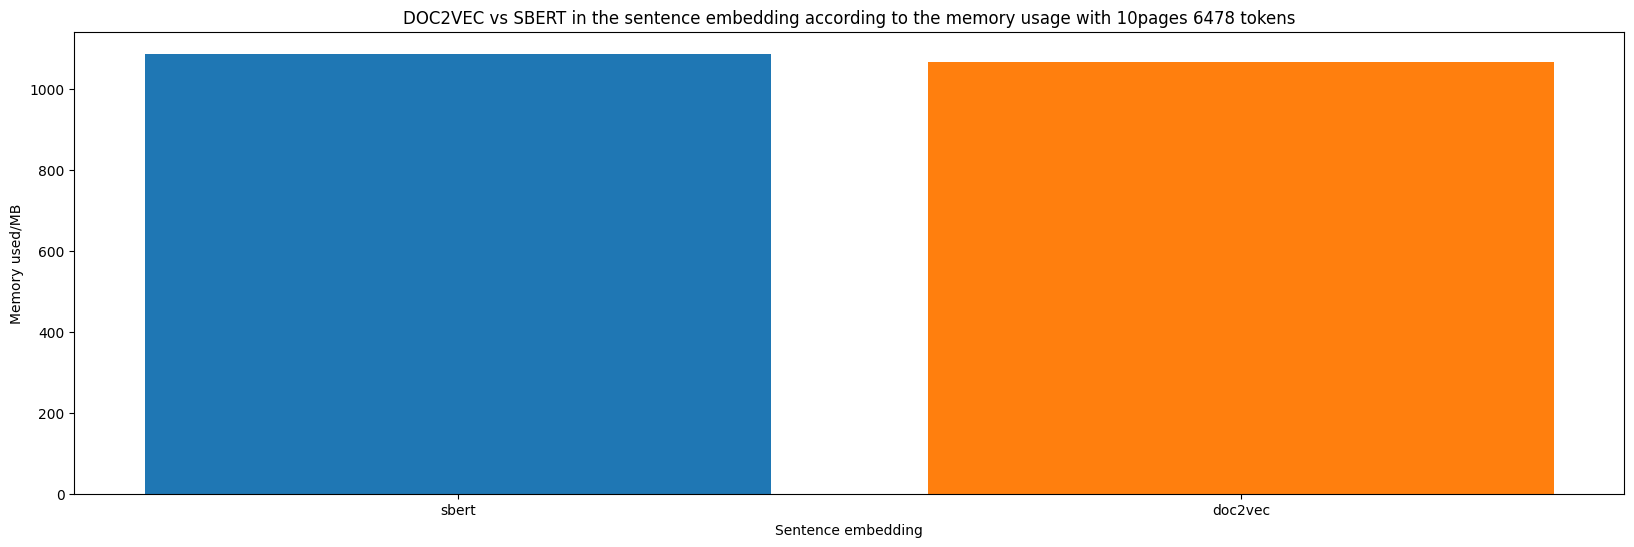

In [ ]:
import matplotlib.pyplot as plt

# Plot the results
plt.figure(figsize=(20, 6))

for threshold, question_count in [('sbert', memory_usage10_sbert),
                                  ('doc2vec', memory_usage10),


                                 ]:
    plt.bar(str(threshold), question_count)

plt.xlabel('Sentence embedding')
plt.ylabel('Memory used/MB')
plt.title('DOC2VEC vs SBERT in the sentence embedding according to the memory usage with 10pages 6478 tokens')
plt.show()


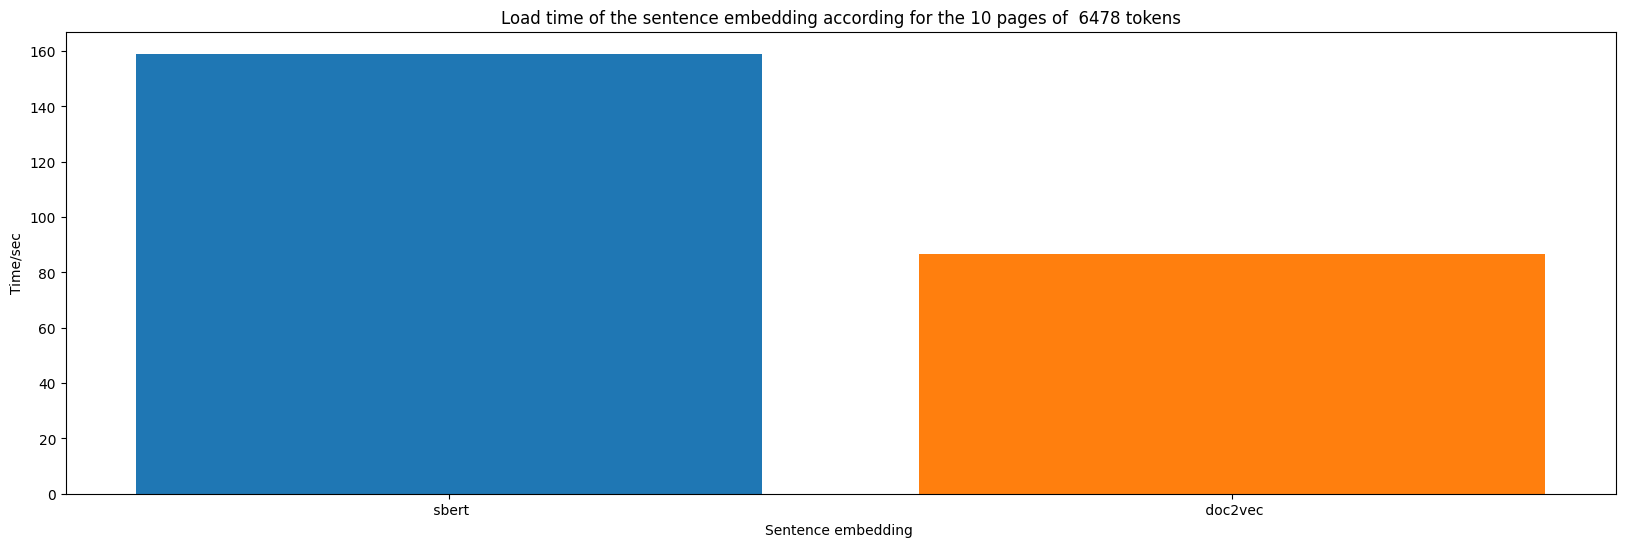

In [ ]:
import matplotlib.pyplot as plt

# Plot the results
plt.figure(figsize=(20, 6))

for threshold, question_count in [(' sbert', elapsed_time_10_sbert),
                                  (' doc2vec', elapsed_time_10),

                                 ]:
    plt.bar(str(threshold), question_count)

plt.xlabel('Sentence embedding ')
plt.ylabel('Time/sec')
plt.title('Load time of the sentence embedding according for the 10 pages of  6478 tokens')
plt.show()


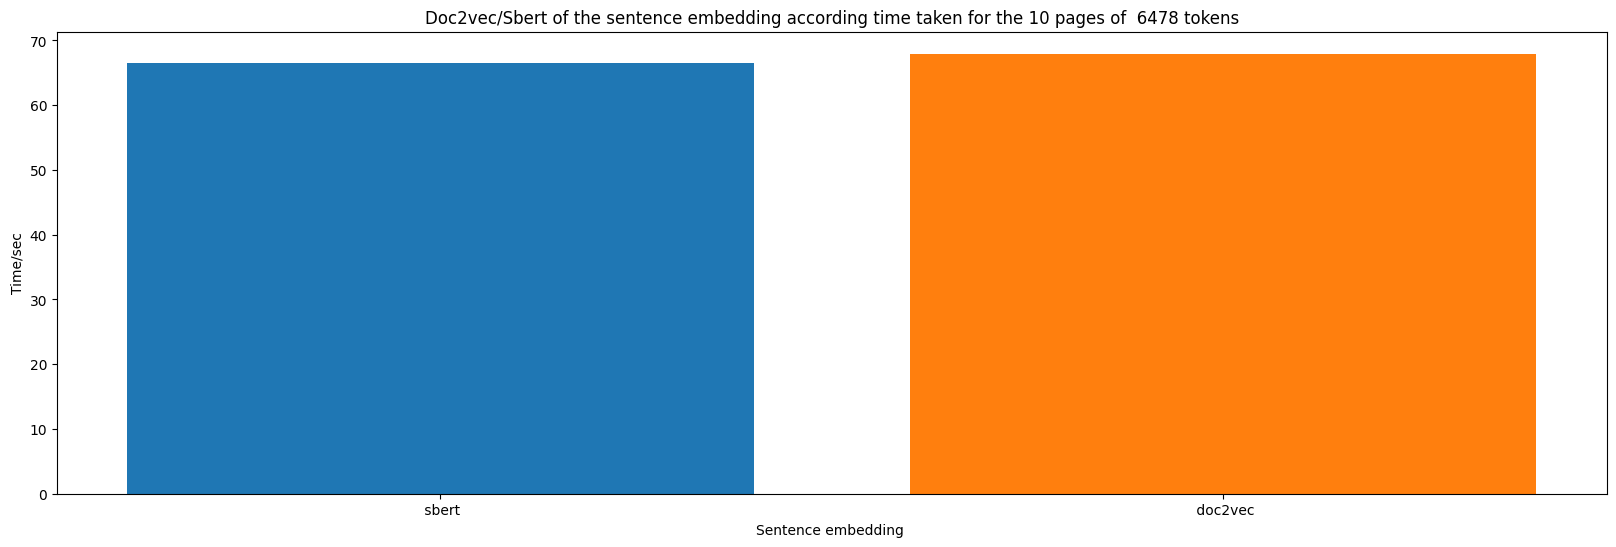

In [ ]:
import matplotlib.pyplot as plt

# Plot the results
plt.figure(figsize=(20, 6))

for threshold, question_count in [(' sbert', elapsed_time10_sbert),
                                  (' doc2vec', elapsed_time10),

                                 ]:
    plt.bar(str(threshold), question_count)

plt.xlabel('Sentence embedding ')
plt.ylabel('Time/sec')
plt.title('Doc2vec/Sbert of the sentence embedding according time taken for the 10 pages of  6478 tokens')
plt.show()


* In this trial, we tried the pdf with 10 pages with 6478 tokens we found that
* The memory ysage is almost the same
* The load time with the doc2vec is less than with sbert
* While the time elapsed with the sbert (with store and embedding compare function) is greater than doc2vec, but with little percentage (not like the loading)
* Also, the average similarity score is about 3% difference (to the sbert) with is not large value
* Both almost gives the same response
* We will choose after trying the next trial


#pdf =https://www.uou.ac.in/sites/default/files/slm/Introduction-cyber-security.pdf

152 pages with 23479 tokens

3 questions and evaluate the response with the true answers


# DOC2VEC

In [ ]:
# Set the URL of the PDF you want to work with
pdf_url = 'https://www.uou.ac.in/sites/default/files/slm/Introduction-cyber-security.pdf'
# Initialize the Words_Digest with the PDF URL
first_approch = First_approach(pdf_url)
# Measure the time it takes
start_time_152 = time.time()
pdf_info = first_approch.kw_emb_store(extract_keywords_yake,generate_emb_doc_2_vec,create_embedding_ada)
end_time_152 = time.time()
elapsed_time_152= end_time_152 - start_time_152
print("Elapsed Time for store with the embeddding sentence (doc2vec):", elapsed_time_152, "seconds")

Elapsed Time for store with the embeddding sentence (doc2vec): 539.456648349762 seconds


In [ ]:
# Set token and similarity thresholds
token_threshold = 500
similarity_threshold = 0.8
# Create a list of indices from the stored PDF info
indices_only = [info[0] for info in pdf_info]
# Initialize conversation history
conversation_history = []
# Start measuring time for the main loop
start_time152 = time.time()
# This is the true answers
ans=['An antivirus program is used to protect a computer system against malicious codes like viruses, worms, trojan horses, etc. It prevents these harmful codes from entering the system and also detects and removes any malicious code that is already present. Additionally, it helps in preventing the spread of viruses, which can cause business and financial loss for organizations.',
                 'To secure a computer, you can follow these steps based on the information provided in the text:Use a password manager: A password manager helps you manage and store passwords securely. It encrypts the passwords, making them difficult for others to exploit.Encryption: Use encryption techniques to convert data into unreadable form before transmitting it over the internet. Encryption locks the data with complex codes that can only be decoded with the correct key.Choose a strong encryption protocol: When using a password manager or any other encryption method, ensure that it uses a strong encryption protocol, such as a 256-bit (or higher) encryption, for better security.Consider online or local storage for password managers: Password managers can be stored online in a cloud or locally on a server. Both have their advantages, so choose the option that suits your needs and concerns.By implementing these measures, you can enhance the security of your computer and safeguard your sensitive information.',
                 'To use social networking platforms safely, you can follow these general tips based on the information provided in the text:Be cautious with personal information: Be mindful of the personal information you share on social networking platforms. Avoid sharing sensitive details like your address, phone number, or financial information.Set strong privacy settings: Take advantage of the privacy settings offered by the social networking platform. Adjust your settings to control who can view your posts, photos, and personal information.Be selective with connections: Connect with individuals you know and trust. Be cautious when accepting friend requests or connections from strangers.Use secure communication methods: Recognize that real-time discussions on social networking platforms may not be completely secure. Avoid sharing sensitive or personal information through these channels.Be aware of cyberbullying and harassment: Report and block any accounts that engage in stalking, harassment, or threatening behavior. Maintain awareness of false accusations, threats, or exploitation targeting minors.Be mindful of malicious activities: Stay vigilant against malicious activities such as injection attacks on trusted websites. Avoid clicking on suspicious links or executing unknown scripts.By following these tips, you can help ensure a safer experience while using social networking platforms and protect yourself from potential cyber threats.']
sim_per=[]
res=[]

for i in range(len(ans)):
    try:
        user_prompt = input("You: ")

        if user_prompt.lower() == "exit":
            break
        # Find similar paragraph indices based on user input and similarity threshold
        similar_paragraph_indices = first_approch.keyword_compare(user_prompt,create_embedding_ada,extract_keywords_yake, similarity_threshold=similarity_threshold)
        print ('similar_paragraph_indices:',similar_paragraph_indices)
        if len(similar_paragraph_indices) == 0:
          # Use all paragraph indices when no similar ones are found
            similar_paragraph_indices=indices_only
            # Get the top indices based on embeddings comparison
            top_indices = first_approch.embeddings_compare(similar_paragraph_indices, user_prompt, embedding_function=generate_emb_doc_2_vec)
            print ('top_indices:',top_indices)
            if len(top_indices) == 0:
              print('The answer to this question is not provided in this PDF')
              continue
            else:
              # Generate a summary and prompt for GPT-3
              summary = first_approch.tokens_check_and_summerization(user_prompt, top_indices, textrank, token_threshold=token_threshold)
              prompt = first_approch.prompt_generator(user_prompt, summary)
              conversation_history.append({"role": "user", "content": prompt})
               # Generate a response from GPT-3
              response = first_approch.run_chatgpt(conversation_history)
              res.append(response)
              print("Assistant's Response:", response)
              # Calculate similarity percentage
              similarity_percentage = first_approch.evaluation(ans[i], response, generate_emb_sbert)
              sim_per.append(similarity_percentage)
              print("Similarity Percentage:", similarity_percentage)
              conversation_history.append({"role": "assistant", "content": response})

        else:
          # Get the top indices based on embeddings comparison
            top_indices = first_approch.embeddings_compare(similar_paragraph_indices, user_prompt, embedding_function=generate_emb_doc_2_vec)
            print ('top_indices:',top_indices)
            # Generate a summary and prompt for GPT-3
            summary = first_approch.tokens_check_and_summerization(user_prompt, top_indices, textrank, token_threshold=token_threshold)
            prompt = first_approch.prompt_generator(user_prompt, summary)
            conversation_history.append({"role": "user", "content": prompt})
             # Generate a response from GPT-3
            response = first_approch.run_chatgpt(conversation_history)
            res.append(response)
            print("Assistant's Response:", response)
            # Calculate similarity percentage
            similarity_percentage = first_approch.evaluation(ans[i], response, generate_emb_sbert)
            sim_per.append(similarity_percentage)
            print("Similarity Percentage:", similarity_percentage)
            conversation_history.append({"role": "assistant", "content": response})

    except openai.error.InvalidRequestError as e:
        print("Error:", e)
        print("Total token count exceeded. Exiting...")
        break

# Measure elapsed time
end_time152 = time.time()
elapsed_time152 = end_time152 - start_time152
print("Elapsed Time:", elapsed_time152, "seconds")

# Measure memory usage
process152 = psutil.Process()
memory_usage152 = process152.memory_info().rss / (1024 * 1024)  # in MB
print("Memory Usage:", memory_usage152, "MB")

#What is an antivirus program used for?in points
#How can you secure a computer?in points
# How can social netwroking platforms be used safely?in points

You: What is an antivirus program used for?in points
similar_paragraph_indices: [2, 14, 26, 33, 35, 36, 45, 47, 48, 49, 51, 54, 76, 79, 81, 83, 86, 87, 89, 90, 91, 97, 101, 123, 129, 137, 140, 147, 148, 154, 172, 174, 175, 176, 195, 196, 202, 216, 221, 223, 225, 230, 232, 240, 246, 250, 252, 256, 257, 270, 278, 280, 285, 294, 295, 298, 302, 313, 321, 331, 341, 357, 363, 372, 390, 394, 401, 412, 437, 459, 462, 477, 478, 479, 483, 487, 489, 493, 496, 505, 507, 511, 514, 517, 518, 521, 527, 531, 538, 544, 545, 547, 550, 554, 556, 582, 584, 585, 589, 591, 597, 599, 600, 601, 604, 605]
top_indices: [302, 76, 547, 412, 256]
Ratio between token_size_summary and token_size_paragraph: 100
Assistant's Response: - An antivirus program is used to protect a computer or device from malicious software such as viruses, malware, spyware, and ransomware.
- It scans and detects potential threats on the computer or device, including suspicious files, websites, and downloads.
- It provides real-time protec

In [ ]:
import pandas as pd
# Here just to print the similarity with the questions and responses in the dataframe
index_list = ['1', '2', '3']
question_list = ['What is an antivirus program used for?', 'How can you secure a computer?', 'How can social netwroking platforms be used safely?']
expected_answer_list = res
true_answer_list = ans
similarity_perc = sim_per

data = {
    'Index': index_list,
    'Question': question_list,
    'Expected_answer': expected_answer_list,
    'True_answer': true_answer_list,
    'Similarity Score': similarity_perc
}

pdf152 = pd.DataFrame(data)
pdf152

,Index,Question,Expected_answer,True_answer,Similarity Score
0,1,What is an antivirus program used for?,- An antivirus program is used to protect a co...,An antivirus program is used to protect a comp...,tensor(92.0758)
1,2,How can you secure a computer?,- Secure your computer by using encryption tec...,"To secure a computer, you can follow these ste...",tensor(81.9685)
2,3,How can social netwroking platforms be used sa...,- Use strong and unique passwords for your soc...,"To use social networking platforms safely, you...",tensor(89.7165)


In [ ]:
# Your list of tensors
import torch

# Convert the list to a PyTorch tensor
tensor_values = torch.stack(sim_per)

# Calculate the average
average_tensor = torch.mean(tensor_values)

# Convert the result back to a regular Python float
average_value = average_tensor.item()

print("Average of similarity score of the 3 questions:", average_value)

Average of similarity score of the 3 questions: 87.9202651977539


#SBERT

In [ ]:
# Set the URL of the PDF you want to work with
pdf_url = 'https://www.uou.ac.in/sites/default/files/slm/Introduction-cyber-security.pdf'
# Initialize the Words_Digest with the PDF URL
first_approch = First_approach(pdf_url)
# Measure the time it takes
start_time_152_sbert = time.time()
pdf_info = first_approch.kw_emb_store(extract_keywords_yake,generate_emb_sbert,create_embedding_ada)
end_time_152_sbert = time.time()
elapsed_time_152_sbert= end_time_152_sbert - start_time_152_sbert
print("Elapsed Time for store with the embeddding sentence (sbert):", elapsed_time_152_sbert, "seconds")

Elapsed Time for store with the embeddding sentence (sbert): 843.583221912384 seconds


In [ ]:
# Set token and similarity thresholds
token_threshold = 500
similarity_threshold = 0.8
# Create a list of indices from the stored PDF info
indices_only = [info[0] for info in pdf_info]
# Initialize conversation history
conversation_history = []
# Start measuring time for the main loop
start_time152_sbert = time.time()
#This is tthe true answers
ans3=['An antivirus program is used to protect a computer system against malicious codes like viruses, worms, trojan horses, etc. It prevents these harmful codes from entering the system and also detects and removes any malicious code that is already present. Additionally, it helps in preventing the spread of viruses, which can cause business and financial loss for organizations.',
                 'To secure a computer, you can follow these steps based on the information provided in the text:Use a password manager: A password manager helps you manage and store passwords securely. It encrypts the passwords, making them difficult for others to exploit.Encryption: Use encryption techniques to convert data into unreadable form before transmitting it over the internet. Encryption locks the data with complex codes that can only be decoded with the correct key.Choose a strong encryption protocol: When using a password manager or any other encryption method, ensure that it uses a strong encryption protocol, such as a 256-bit (or higher) encryption, for better security.Consider online or local storage for password managers: Password managers can be stored online in a cloud or locally on a server. Both have their advantages, so choose the option that suits your needs and concerns.By implementing these measures, you can enhance the security of your computer and safeguard your sensitive information.',
                 'To use social networking platforms safely, you can follow these general tips based on the information provided in the text:Be cautious with personal information: Be mindful of the personal information you share on social networking platforms. Avoid sharing sensitive details like your address, phone number, or financial information.Set strong privacy settings: Take advantage of the privacy settings offered by the social networking platform. Adjust your settings to control who can view your posts, photos, and personal information.Be selective with connections: Connect with individuals you know and trust. Be cautious when accepting friend requests or connections from strangers.Use secure communication methods: Recognize that real-time discussions on social networking platforms may not be completely secure. Avoid sharing sensitive or personal information through these channels.Be aware of cyberbullying and harassment: Report and block any accounts that engage in stalking, harassment, or threatening behavior. Maintain awareness of false accusations, threats, or exploitation targeting minors.Be mindful of malicious activities: Stay vigilant against malicious activities such as injection attacks on trusted websites. Avoid clicking on suspicious links or executing unknown scripts.By following these tips, you can help ensure a safer experience while using social networking platforms and protect yourself from potential cyber threats.']
sim_per3=[]
res3=[]

for i in range(len(ans3)):
    try:
        user_prompt = input("You: ")

        if user_prompt.lower() == "exit":
            break
        # Find similar paragraph indices based on user input and similarity threshold
        similar_paragraph_indices = first_approch.keyword_compare(user_prompt,create_embedding_ada,extract_keywords_yake, similarity_threshold=similarity_threshold)
        print ('similar_paragraph_indices:',similar_paragraph_indices)
        if len(similar_paragraph_indices) == 0:
          # Use all paragraph indices when no similar ones are found
            similar_paragraph_indices=indices_only
            # Get the top indices based on embeddings comparison
            top_indices = first_approch.embeddings_compare(similar_paragraph_indices, user_prompt, embedding_function=generate_emb_sbert)
            print ('top_indices:',top_indices)
            if len(top_indices) == 0:
              print('The answer to this question is not provided in this PDF')
              continue
            else:
              # Generate a summary and prompt for GPT-3
              summary = first_approch.tokens_check_and_summerization(user_prompt, top_indices, textrank, token_threshold=token_threshold)
              prompt = first_approch.prompt_generator(user_prompt, summary)
              conversation_history.append({"role": "user", "content": prompt})
              # Generate a response from GPT-3
              response = first_approch.run_chatgpt(conversation_history)
              res3.append(response)
              print("Assistant's Response:", response)
              # Calculate similarity percentage
              similarity_percentage = first_approch.evaluation(ans3[i], response, generate_emb_sbert)
              sim_per3.append(similarity_percentage)
              print("Similarity Percentage:", similarity_percentage)
              conversation_history.append({"role": "assistant", "content": response})

        else:
          # Get the top indices based on embeddings comparison
            top_indices = first_approch.embeddings_compare(similar_paragraph_indices, user_prompt, embedding_function=generate_emb_sbert)
            print ('top_indices:',top_indices)
            # Generate a summary and prompt for GPT-3
            summary = first_approch.tokens_check_and_summerization(user_prompt, top_indices, textrank, token_threshold=token_threshold)
            prompt = first_approch.prompt_generator(user_prompt, summary)
            conversation_history.append({"role": "user", "content": prompt})
            # Generate a response from GPT-3
            response = first_approch.run_chatgpt(conversation_history)
            res3.append(response)
            print("Assistant's Response:", response)
            # Calculate similarity percentage
            similarity_percentage = first_approch.evaluation(ans3[i], response, generate_emb_sbert)
            sim_per3.append(similarity_percentage)
            print("Similarity Percentage:", similarity_percentage)
            conversation_history.append({"role": "assistant", "content": response})

    except openai.error.InvalidRequestError as e:
        print("Error:", e)
        print("Total token count exceeded. Exiting...")
        break

# Measure elapsed time
end_time152_sbert = time.time()
elapsed_time152_sbert = end_time152_sbert - start_time152_sbert
print("Elapsed Time:", elapsed_time152_sbert, "seconds")

# Measure memory usage
process152_sbert = psutil.Process()
memory_usage152_sbert = process152_sbert.memory_info().rss / (1024 * 1024)  # in MB
print("Memory Usage:", memory_usage152_sbert, "MB")

#What is an antivirus program used for?in points
#How can you secure a computer?in points
# How can social netwroking platforms be used safely?in points

You: What is an antivirus program used for?in points
similar_paragraph_indices: [2, 14, 26, 33, 35, 36, 45, 47, 48, 49, 51, 54, 76, 79, 81, 83, 86, 87, 89, 90, 91, 97, 101, 123, 129, 137, 140, 147, 148, 154, 172, 174, 175, 176, 195, 196, 202, 216, 221, 223, 225, 230, 232, 240, 246, 250, 252, 256, 257, 270, 278, 280, 285, 294, 295, 298, 302, 313, 321, 331, 341, 357, 363, 372, 390, 394, 401, 412, 437, 459, 462, 477, 478, 479, 483, 487, 489, 493, 496, 505, 507, 511, 514, 517, 518, 521, 527, 531, 538, 544, 545, 547, 550, 554, 556, 582, 584, 585, 589, 591, 597, 599, 600, 601, 604, 605]
top_indices: [176, 172, 175, 51, 49]
Ratio between token_size_summary and token_size_paragraph: 83.1758034026465
Assistant's Response: 1. An antivirus program is used to protect computers against viruses, Trojans, worms, rootkits, and other malicious programs.
2. It detects and removes these threats to ensure the security and stability of the computer system.
3. Antivirus programs provide real-time scanning a

In [ ]:
import pandas as pd
# Here just to print the similarity with the questions and responses in the dataframe
index_list3 = ['1', '2', '3']
question_list3 = ['What is an antivirus program used for?', 'How can you secure a computer?', 'How can social netwroking platforms be used safely?']
expected_answer_list3 = res3
true_answer_list3 = ans3
similarity_perc3 = sim_per3

data = {
    'Index': index_list3,
    'Question': question_list3,
    'Expected_answer': expected_answer_list3,
    'True_answer': true_answer_list3,
    'Similarity Score': similarity_perc3
}

pdf152 = pd.DataFrame(data)
pdf152

,Index,Question,Expected_answer,True_answer,Similarity Score
0,1,What is an antivirus program used for?,1. An antivirus program is used to protect com...,An antivirus program is used to protect a comp...,tensor(92.6147)
1,2,How can you secure a computer?,1. Install antivirus software to protect again...,"To secure a computer, you can follow these ste...",tensor(79.3006)
2,3,How can social netwroking platforms be used sa...,1. Understand the security implications of usi...,"To use social networking platforms safely, you...",tensor(91.8809)


In [ ]:
# Your list of tensors
import torch

# Convert the list to a PyTorch tensor
tensor_values = torch.stack(sim_per3)

# Calculate the average
average_tensor = torch.mean(tensor_values)

# Convert the result back to a regular Python float
average_value = average_tensor.item()

print("Average of similarity score of the 3 questions:", average_value)

Average of similarity score of the 3 questions: 87.93206787109375


#Plot the memory usage , loaded time and the time elapsed

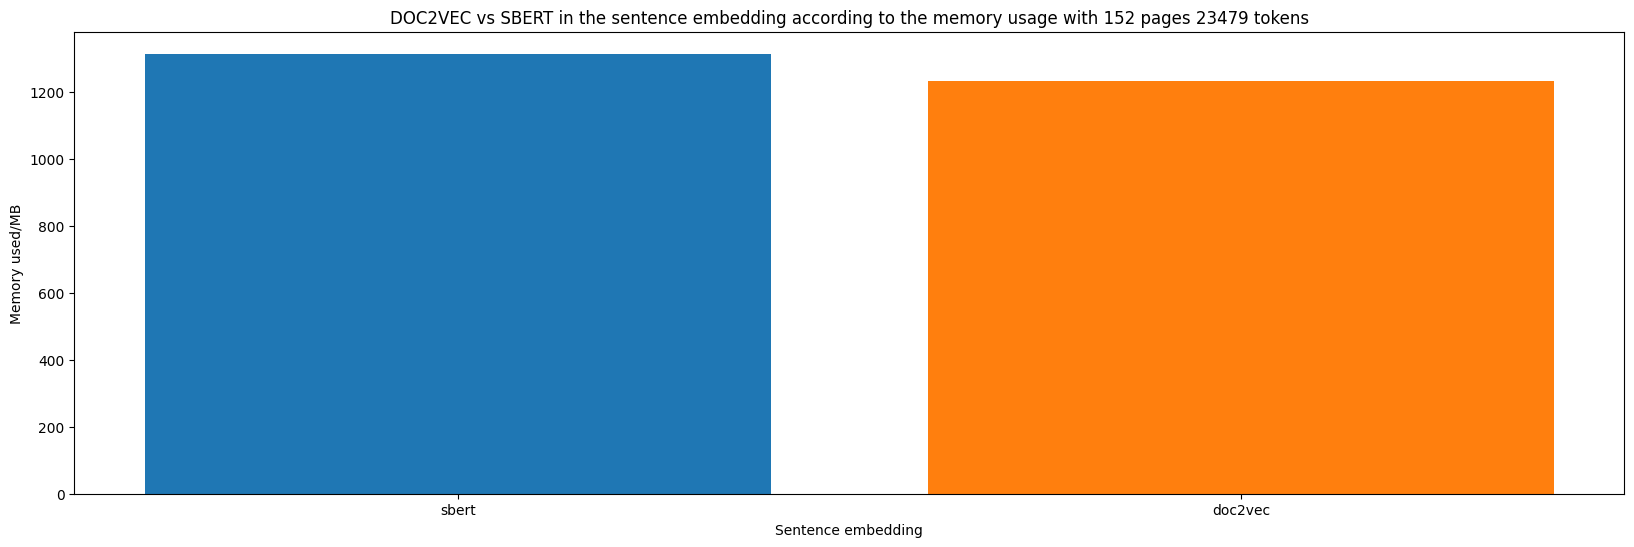

In [ ]:
import matplotlib.pyplot as plt

# Plot the results
plt.figure(figsize=(20, 6))

for threshold, question_count in [('sbert', memory_usage152_sbert),
                                  ('doc2vec', memory_usage152),


                                 ]:
    plt.bar(str(threshold), question_count)

plt.xlabel('Sentence embedding')
plt.ylabel('Memory used/MB')
plt.title('DOC2VEC vs SBERT in the sentence embedding according to the memory usage with 152 pages 23479 tokens')
plt.show()


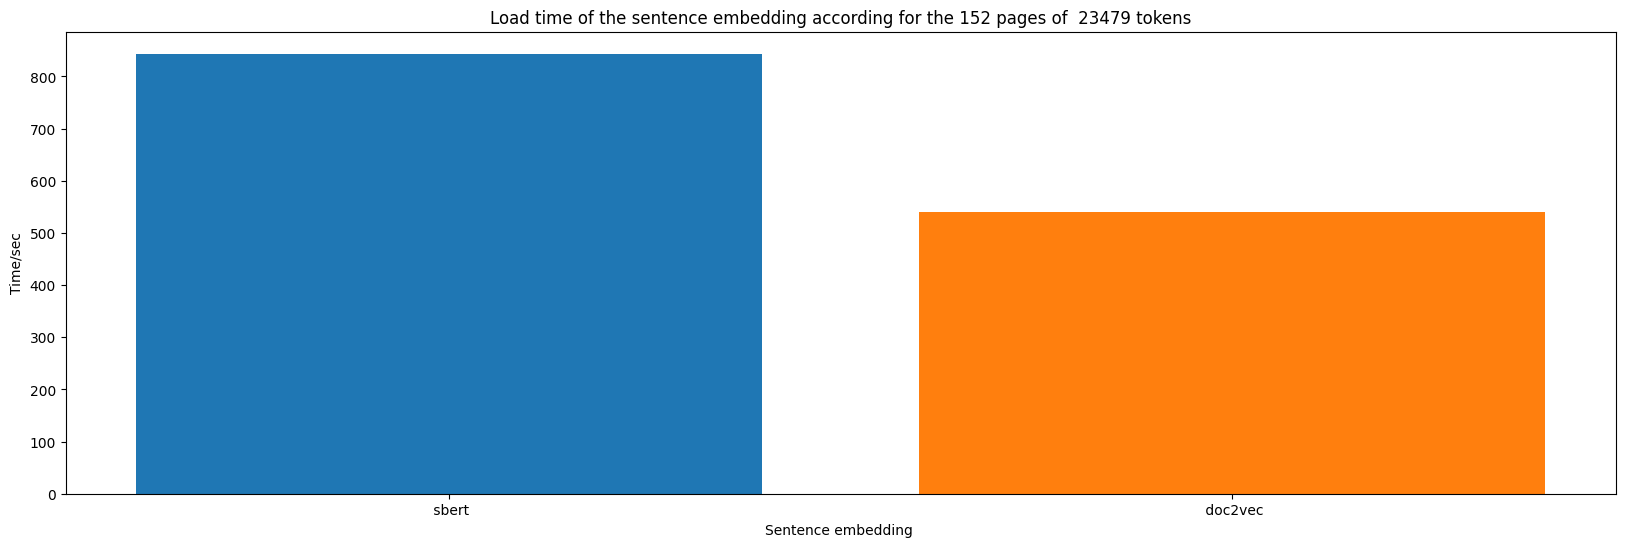

In [ ]:
import matplotlib.pyplot as plt

# Plot the results
plt.figure(figsize=(20, 6))

for threshold, question_count in [(' sbert', elapsed_time_152_sbert),
                                  (' doc2vec', elapsed_time_152),

                                 ]:
    plt.bar(str(threshold), question_count)

plt.xlabel('Sentence embedding ')
plt.ylabel('Time/sec')
plt.title('Load time of the sentence embedding according for the 152 pages of  23479 tokens')
plt.show()


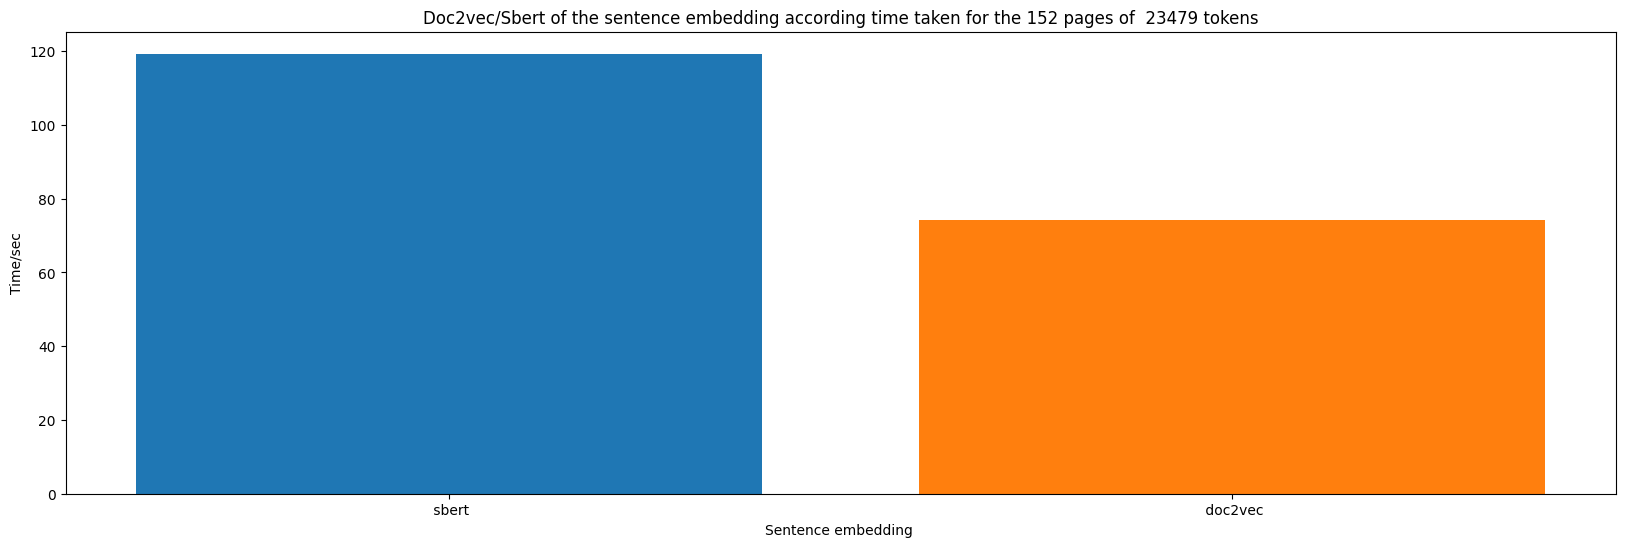

In [ ]:
import matplotlib.pyplot as plt

# Plot the results
plt.figure(figsize=(20, 6))

for threshold, question_count in [(' sbert', elapsed_time152_sbert),
                                  (' doc2vec', elapsed_time152),

                                 ]:
    plt.bar(str(threshold), question_count)

plt.xlabel('Sentence embedding ')
plt.ylabel('Time/sec')
plt.title('Doc2vec/Sbert of the sentence embedding according time taken for the 152 pages of  23479 tokens')
plt.show()


* In this trial, we tried the pdf with 152 pages with 23479 tokens we found that
* The memory ysage is almost the same
* The load time with the doc2vec is less than with sbert
* The elapsed time with the doc2vec is less than with sbert
* Also, the average similarity score of them is almost the same
* Both almost gives the same response
* We will choose doc2vec (with ada, yake, textrank, 500 threshold, with keyword)

# Plot the time taken for the 2 pdfs

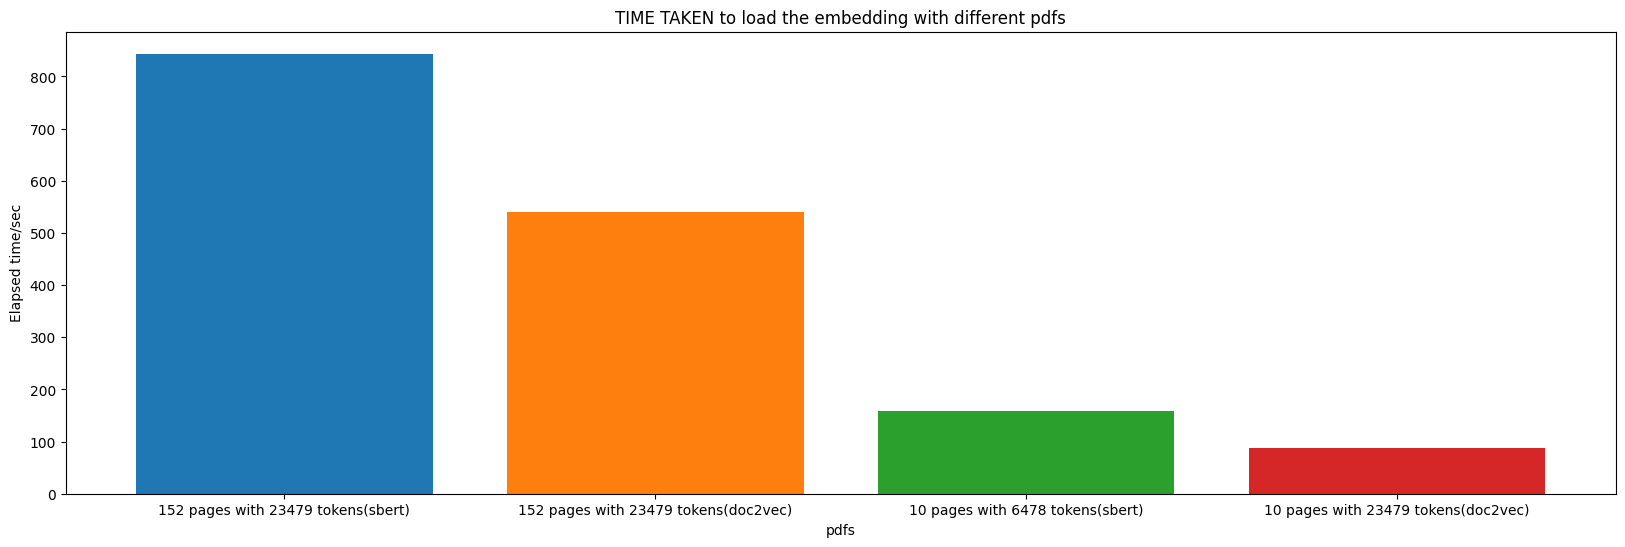

In [ ]:
import matplotlib.pyplot as plt

# Plot the results
plt.figure(figsize=(20, 6))

for threshold, question_count in [('152 pages with 23479 tokens(sbert)', elapsed_time_152_sbert),
                                  ('152 pages with 23479 tokens(doc2vec)', elapsed_time_152),
                                  ('10 pages with 6478 tokens(sbert)', elapsed_time_10_sbert),
                                  ('10 pages with 23479 tokens(doc2vec)', elapsed_time_10),
                                 ]:
    plt.bar(str(threshold), question_count)

plt.xlabel('pdfs')
plt.ylabel('Elapsed time/sec')
plt.title('TIME TAKEN to load the embedding with different pdfs')
plt.show()

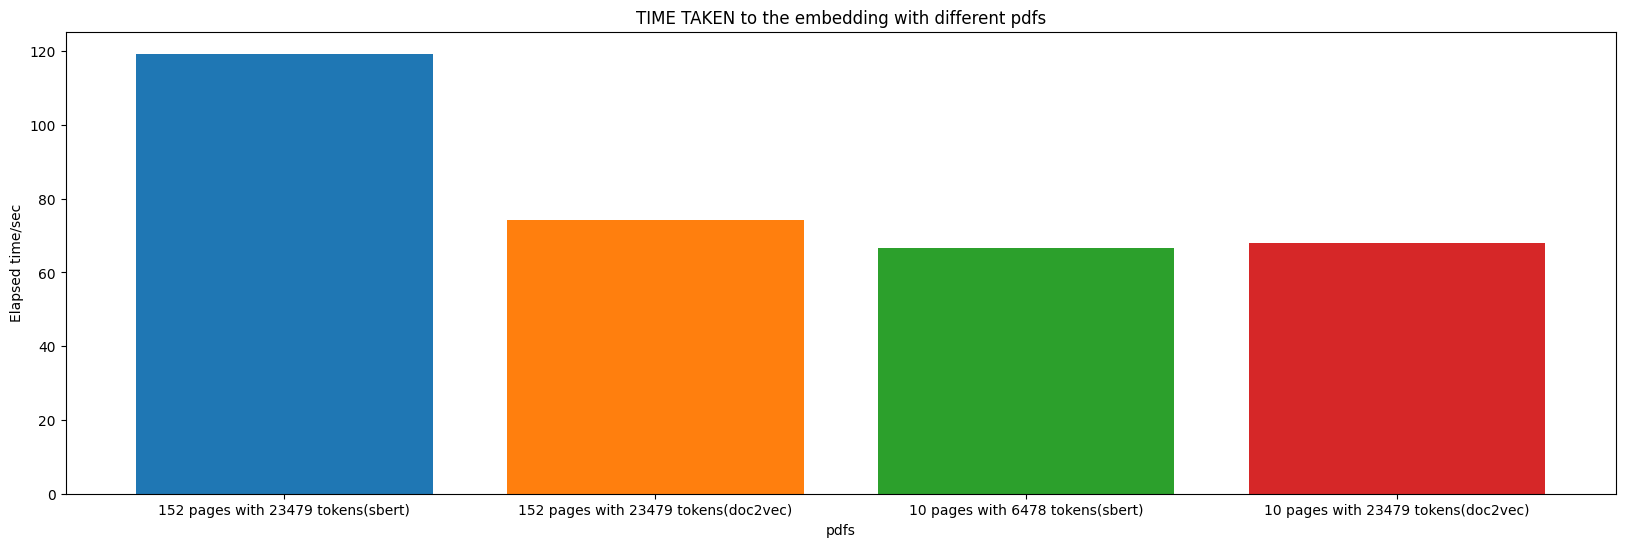

In [ ]:
import matplotlib.pyplot as plt

# Plot the results
plt.figure(figsize=(20, 6))

for threshold, question_count in [('152 pages with 23479 tokens(sbert)', elapsed_time152_sbert),
                                  ('152 pages with 23479 tokens(doc2vec)', elapsed_time152),
                                  ('10 pages with 6478 tokens(sbert)', elapsed_time10_sbert),
                                  ('10 pages with 23479 tokens(doc2vec)', elapsed_time10),
                                 ]:
    plt.bar(str(threshold), question_count)

plt.xlabel('pdfs')
plt.ylabel('Elapsed time/sec')
plt.title('TIME TAKEN to the embedding with different pdfs')
plt.show()

* This graphs shows that the loading time of the sbert in every trail is large
* When the number of tokens decrease, the load time and the elapsed time decrease

# Conclusion

* We will use threshold = 500, as it does not loss inforamtions and takes large number of questions

* We choose doc2vec as embedding function (in the store & embedding_compare functions) as it takes less time and gives accurate response

* We will use ada as word embedding to the keyword as it takes less time and gives good response

* We will use textrank as summarization library , as it gives accurate summary without loosing on the information and takes less time

* We will use yake as keyword extractor as it take less time

* We compare them according to the time of load or elapsing or both of them

* Time of load : as we do not need to read the pdf in long time

* Elapsed time : as we do not need to take long time to get the response